# Pharmacy Store Sales Forecast

In this project I will develop a __model capable of predicting the sales__ of Rossmann pharmacy stores through __regression machine learning algorithms__, based on previously collected sales data.

The project will follow the __CRISP-DM methodology__ as described below:
* 1. Understand and define the business problem
* 2. Collect data
* 3. Obtain a general understanding of the dataset
* 4. Cleaning and pre-processing of data
* 5. Descriptive statistics
* 6. Creation of exploratory hypotheses (empirical)
* 7. Feature Engineering
* 8. Features Filter
* 9. Exploratory Data Analysis (EDA), through validation or not of the hypotheses created
* 10. Data preparation (rescaling, encoding and transformation)
* 11. Split into training and test dataset
* 12. Feature selection (Boruta)
* 13. Machine Learning Modeling (average, linear regression, linear regression regularized, random forest and XGboost)
* 14. Compare model’s performance
* 15. Hyperparameters Finetuning (Random search)
* 16. Training the final model and predicting (XGBoost)
* 17. Translate and interpret the error creating best and worst case scenarios of predictions based on the error (MAE)
* 18. Deploy the model to production

# 1. BUSINESS PROBLEM

* Rossmann operates over 3,000 drug stores in 7 European countries. Currently, __Rossmann store managers__ are tasked with __predicting their daily sales for up to six weeks in advance__. Store sales are influenced by many factors, including __promotions, competition, school and state holidays, seasonality, and locality__. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

* What is the __goal__? 
    * To __predict 6 weeks of daily sales for 1,115 stores__ located across Germany, in order to __create effective staff schedules that increase productivity and motivation__. 

* __Which are the benefits?__ 
    * Help store managers __stay focused__ on what's most important to them: their customers and their teams. 
    * Find out which are the main metrics that influence store sales. 
    * Plan future strategic investments.

# 1. IMPORTS

## 1.1 Importing Libraries

In [4]:
# Data manipulations and visualization.

import pandas    as pd
import numpy     as np
import math
import datetime
import seaborn   as sns
import pickle
import calendar
import xgboost   as xgb
import random
from tabulate import tabulate
from IPython.display       import Image
from scipy                 import stats  as ss
from matplotlib            import pyplot as plt
import inflection
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                import BorutaPy
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.ensemble      import RandomForestRegressor

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')


## 1.2 Helper Functions

In [5]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [6]:
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
    'MAE': mae,
    'MAPE': mape,
    'RMSE': rmse }, index=[0] )

In [7]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
        # model
        m = model.fit( xtraining, ytraining )
        # prediction
        yhat = m.predict( xvalidation )
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat ) )
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
    'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
    'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
    'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )

In [8]:
# Função para contar o número de meses de promoção até a data atual
def count_promo_periods(row):
    if pd.isna(row['promo_interval']) or row['promo_interval'] == '':
        return 0
    # Lista de meses de promoção
    promo_months = row['promo_interval'].split(',')
    # Converter nomes dos meses para números
    month_to_num = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    promo_months = [month_to_num[month] for month in promo_months if month in month_to_num]
    
    # Contar os meses de promoção desde o início da promoção até a data atual
    count = 0
    current_date = row['promo2_since']
    while current_date <= row['date']:
        if current_date.month in promo_months:
            count += 1
        # Avançar um mês usando relativedelta
        current_date += relativedelta(months=1)
    
    return count


In [9]:
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

In [10]:
def barplot (dataset, x, y, title, fmt):
    sns.set_theme(style="white", palette='dark')
    plot = sns.barplot( x=x, y = y, data=dataset)
    plt.title(title, fontsize=9, fontweight='bold')
    plt.ylabel('')
    plt.xlabel('')
    plt.yticks([])
    plot.bar_label(plot.containers[0], fmt=fmt, fontsize=8, fontweight='bold'); 

## 1.3 Loading Data

* The dataset was provided by Rossmann Kaggle Compatition in the link: https://www.kaggle.com/c/rossmann-store-sales

In [11]:
# Load datasets.
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

# Merge datasets.
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 2. DATA DESCRIPTION

In [12]:
df1 = df_raw.copy()
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


* Every observation (line) is a sales day of a given store.

Columns Dictionary:
* __Store__: a unique Id for each store
* __DayOfWeek__: week day in numbers:
    * 1 = monday
    * 2 = tuesday
    * 3 = wednesday
    * 4 = thrusday
    * 5 = friday
    * 6 = saturday
    * 7 = sunday
* __Date__: date of the observation
* __Sales__ : the turnover for any given day (this is what you are predicting)
* __Customers__: the number of customers on a given day
* __Open__: an indicator for whether the store was open: 
    * 0 = closed
    * 1 = open
* __StateHoliday__: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. 
    * a = public holiday
    * b = Easter holiday
    * c = Christmas
    * 0 = None
* __SchoolHoliday__: indicates if the (Store, Date) was affected by the closure of public schools
* __StoreType__: differentiates between 4 different store models: a, b, c, d
* __Assortment__: describes an assortment level: 
    * a = basic
    * b = extra
    * c = extended
* __CompetitionDistance__: distance in meters to the nearest competitor store
* __CompetitionOpenSince[Month/Year]__: gives the approximate year and month of the time the nearest competitor was opened
* __Promo__: indicates whether a store is running a promo on that day
* __Promo2__: Promo2 is a continuing and consecutive promotion for some stores: 
    * 0 = store is not participating
    * 1 = store is participating
* __Promo2Since[Year/Week]__: describes the year and calendar week when the store started participating in Promo2
* __PromoInterval__: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. 
    * E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

Checking the dataset size and general information about the dataset: 

In [13]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [15]:
stores_count = df1['Store'].nunique()
days_count = df1['Date'].nunique()

print(f'The dataset contains sales information about {stores_count} stores during {days_count} days.')



The dataset contains sales information about 1115 stores during 942 days.


## 2.1. Rename Columns

Convert the column names to snake_case using the "Inflection" library. This increases readability and ensures that the names are consistent and easy to parse.

In [16]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
             'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
             'CompetitionDistance', 'CompetitionOpenSinceMonth',
             'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
             'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# Rename columns.
df1.columns = cols_new

## 2.2 Data types

Checking the data types, but first I will transform the 'date' column in datetime.

In [17]:
# Checking data types.
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [18]:
# Convert 'date' to datetime type.
df1['date'] = pd.to_datetime(df1['date'])

## 2.3 Check NA

In [19]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 2.4 Fillout NA

Filling out NA's methods:

* __'competition_distance'__: The NA cells will be replaced by a high numer (=200000.0) in order to be easily identified later in the analysis.
* __'competition_open_since_month'__: The NA cells will be filled by 'date' column information.
* __'competition_open_since_year'__: The NA cells will be filled by 'date' column information.
* __'promo2_since_week'__: The NA cells will be filled by 'date' column information.
* __'promo2_since_year'__: The NA cells will be filled by 'date' column information.
* __'promo_interval'__: Substitute NA cells by '0'. 

Creating two new columns:
* __'month_map'__: Create a dictionary with the number of each month and input the month name based in the 'date' column.
* __'is_promo2'__: Create a column to identify if the store is currently running an extended promotion or not (0 = not running a promotion; 1 = currently running a promotion).

In [20]:
# competition_distance (2642).
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month (323348).
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis =1)

# competition_open_since_year (323348).
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis =1)

# promo2_since_week (508031).
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis =1)

# promo2_since_year (508031).
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis =1)

# promo_interval (508031).
df1['promo_interval'].fillna(0, inplace=True)

# month_map column creation.
month_map = {1: 'Jan', 2: 'Fev',3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['month_map'] = df1['date'].dt.month.map(month_map)

# is_promo column creation.
# df1['is_promo2'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [21]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
dtype: int64

## 2.5 Change Types

Checking again the data types and then changing to coherent types

In [22]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
dtype: object

In [23]:
# Changing data types.

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

In [24]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
dtype: object

## 2.6 Descriptive Statistics

Taking a look in the general data descriptive statistic, but first let's separate in variables the numeric and the categorical attributes.

In [25]:
num_attributes = df1.select_dtypes(include=['int', 'float'])
cat_attributes = df1.select_dtypes(exclude=['int', 'float', 'datetime64[ns]'])

### 2.6.1 Numerical Attributes

In [26]:
# Central Tendency Calculation: mean and median.
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion Calculation: std, min, max, range, skew and kurtosis.
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenating.
m = pd.concat([ d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [27]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


Uderstanding SKEW and KURTOSIS:
* SKEW: The higher (positive) the skew, the more the distribution curve will be shifted to the left. If it is close to zero, it means that the curve is close to a normal distribution.
* KURTOSIS: Represents the size of the peak of the distribution. The higher the KURTOSIS, the higher the peak.

Some insights over the data:
* The maximum sales in a day in a store was $41,551.0, with an average of $5,773.0 per day.
* The maximum number of customers recorded in a store in a day was 41551, with each store registering an average of 633 customers per day.
* The store with the closest competitor is 20 meters away from this competitor.
* The high skew and kurtosis of 'competition_distance' indicates that there are a large number of stores with competitors within short distances (to the left of the distribution chart).
* Extended promotions (indicated by the promo2_since_week column) began in 2009.

Let's take a look in the sales column distribuition:

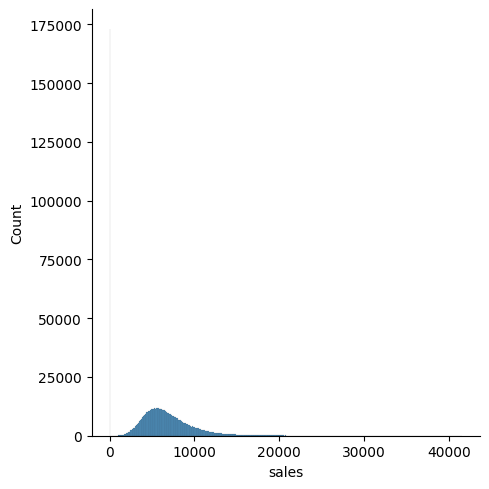

In [28]:
sns.displot(df1['sales'])

### 2.6.2 Categorical Attributes

In [29]:
# Checking unique values number in the categorical variables.

cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [30]:
df1['state_holiday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

Text(0, 0.5, 'Sales ($)')

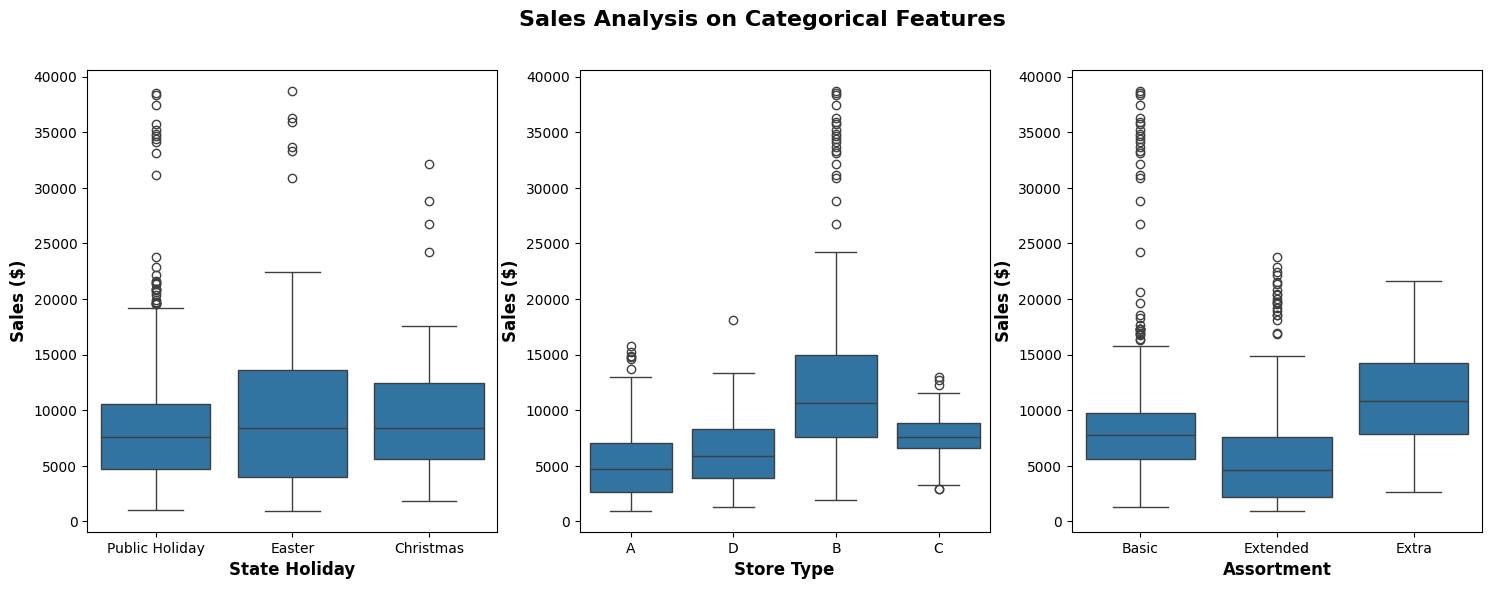

In [31]:
# Excluding the holidays and the days the sales column = 0 (i.e. the days the stores are closed).
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# Rename the categories.
aux1['state_holiday'] = aux1['state_holiday'].replace({
    'a': 'Public Holiday',
    'b': 'Easter',
    'c': 'Christmas'
})
aux1['store_type'] = aux1['store_type'].replace({
    'a': 'A',
    'b': 'B',
    'c': 'C',
    'd': 'D'
})
aux1['assortment'] = aux1['assortment'].replace({
    'a': 'Basic',
    'b': 'Extra',
    'c': 'Extended'
})


plt.figure(figsize=(18, 6))
plt.suptitle('Sales Analysis on Categorical Features', fontsize=16, fontweight='bold')

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)
plt.xlabel('State Holiday', fontsize=12, fontweight='bold')
plt.ylabel('Sales ($)', fontsize=12, fontweight='bold')

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)
plt.xlabel('Store Type', fontsize=12, fontweight='bold')
plt.ylabel('Sales ($)', fontsize=12, fontweight='bold')

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)
plt.xlabel('Assortment', fontsize=12, fontweight='bold')
plt.ylabel('Sales ($)', fontsize=12, fontweight='bold')


Insights: 
* Christmas and Easter days have similar sales median, despite during easter the distribuition tends to be higher.
* The store type "B" has a higher median in relation to the others store types, and relative higher number of outliers.
* The store type "C" is the second hiest median, however the values are concentrated around the median, indicating a more consistent distribution.
* The stores with Extra Assortments shows a higher median of sales in comparison to the other kind of assortments.

In [32]:
df2 = df1.copy()

# 3. HYPOTHESIS CREATION

After a general understanding of the data, hypotheses will be created through brainstorming in order to more precisely guide the Feature Engineering and Exploratory Data Analysis (EDA) steps.

## 3.1 Mind Map Hypothesis

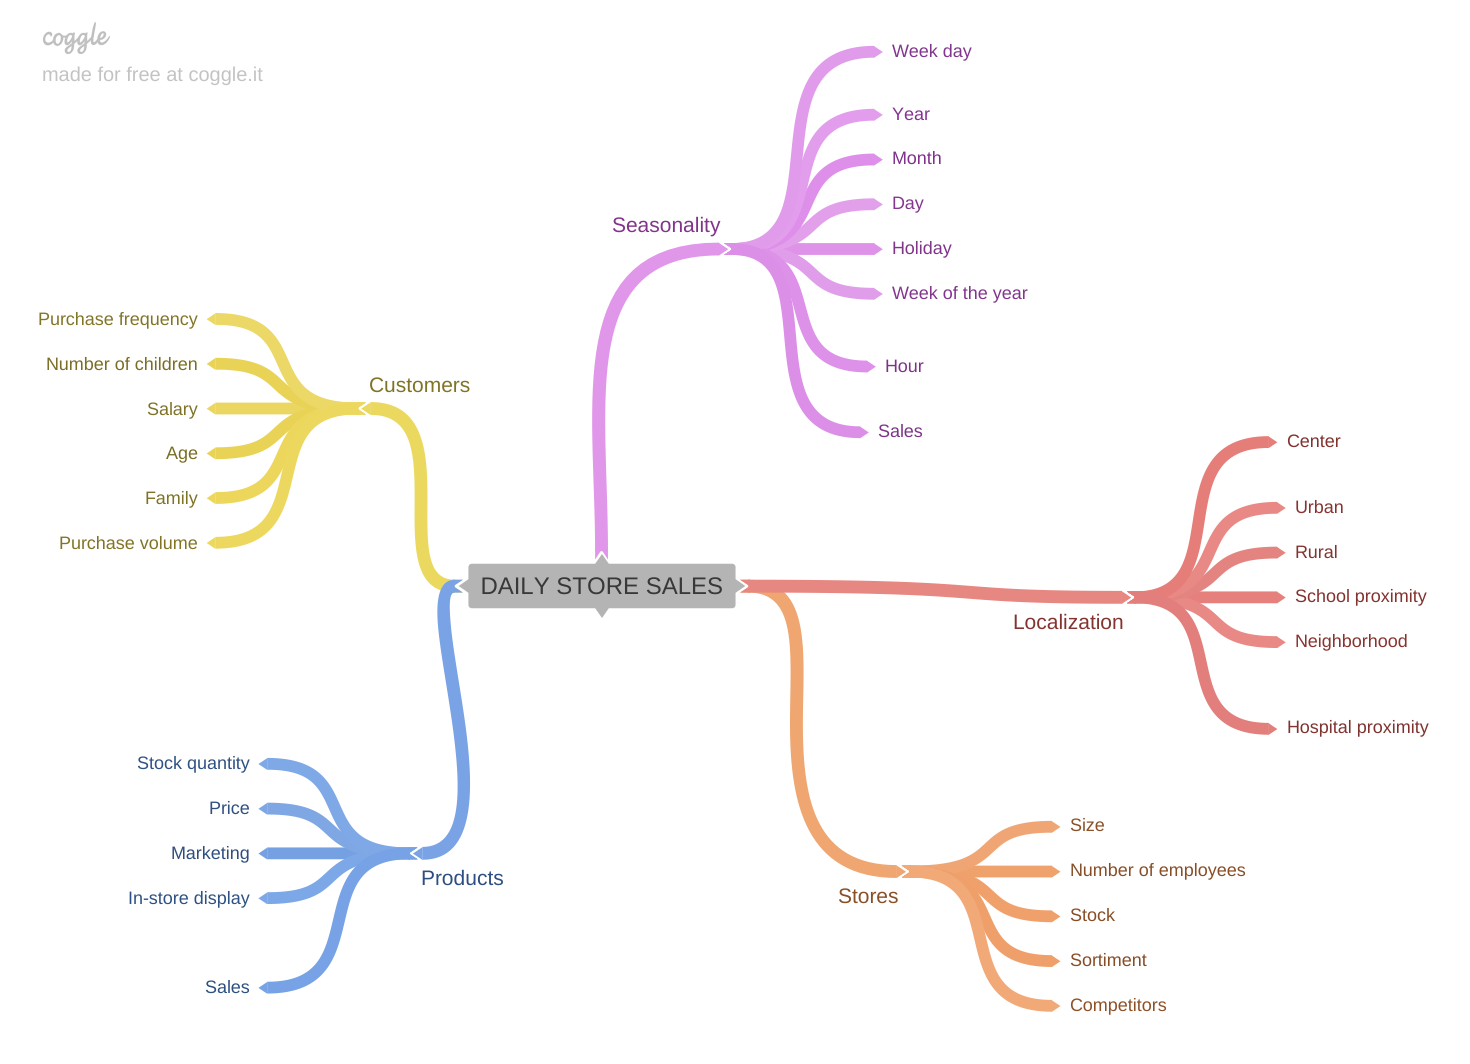

In [33]:
Image('../img/MindMapHypotesis.png')

## 3.2 Hiphotesis Exploration

### 3.2.1 Store Hypothesis

**1.** Stores with larger staff should sell more

**2.** Stores with larger inventory should sell more.

**3.** Larger stores should sell more.

**4.** Smaller stores should sell less.

**5.** Stores with larger assortment should sell more.

### 3.2.2 Product Hypothesis

**1.** Stores that invest more in marketing should sell more.

**2.** Stores that display their products more in their display windows should sell more.

**3.** Stores that have lower prices on their products should sell more.

**4.** Stores that have lower prices for a longer time should sell more.

### 3.2.3 Time Hypothesis

**1.** Stores that have more holidays should sell less.

**2.** Stores that are in the first 6 months after opening should sell more.

**3.** Stores that open on weekends should sell more.

## 3.3 Hypothesis Final List

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer-standing competitors should sell more.


**4.** Stores with promotions running for longer should sell more.

**5.** Stores with more days of promotion should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holidays should sell more

**8.** Stores should sell more throughout the year.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

# 4. FEATURE ENGINEERING

In order to perform a more complete and efficient exploratory data analysis, the feature engineering step will be carried out before EDA.

* __'year'__: Create a year column based on 'date'
* __'month'__: Create a month column based on 'date'
* __'day'__: Create a day column based on 'date'
* __'week_of_year'__: Create a column with the relative number of the week in a year based on 'date'
* __'year_week'__: Create a column with the Year-Week (week is the number of the week in the year)
* __'competition_open_since_year'__: Create a column with the year the nearest competitor was opened
* __'competition_open_since_month'__: Create a column with the month the nearest competitor was opened
* __'competition_time_month'__: Create a column with the time in months of how long the nearest competitor was open.
* __'promo2_since'__: Create a column with the date that started the extended promo.
* __'promo2_time_week'__: Create a column with the number of weeks since the start of the extended promotion.
* __'assortment'__: Just rename the categories based in the information given by the business team.
* __'state_holiday'__: Just rename the categories based in the information given by the business team.
* __'promo2_count'__: Create a column with the quantity of months the store participated of the extended promotion.
* __'is_promo2'__: Create a column to identify days that are current in a extended promotion.
* __'semester'__: Create a column to identify the semester of the year.

In [34]:
df2 = df1.copy()

In [35]:
# year.
df2['year'] = df2['date'].dt.year

# month.
df2['month'] = df2['date'].dt.month

# day.
df2['day'] = df2['date'].dt.day
    
# week_of_year.
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year_week.
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition_since in year and month.
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1), axis=1)

# Competition_time_month.
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) /30).apply(lambda x: x.days)
df2['competition_time_month'].astype(int)

# promo2_since.
df2['promo2_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo2_since'] = df2['promo2_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

# promo2_time_week.
df2['promo2_time_week'] = ((df2['date'] - df2['promo2_since']) /7).apply(lambda x: x.days).astype(int)

# assortment.
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x== 'b' else 'extended')

# state_holiday.
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular day')

# promo2_periods_count.
df2['promo_interval'] = df2['promo_interval'].apply(lambda x: x if isinstance(x, str) else '')
df2['promo2_periods_count'] = df2.apply(count_promo_periods, axis=1)

# is_promo2.
df2['is_promo2'] = df2.apply(
    lambda x: 1 if (x['promo_interval'] != 0 and
                    x['month_map'] in x['promo_interval'].split(',') and
                    df2.loc[df2.index == x.name, 'year'].values[0] >= df2.loc[df2.index == x.name, 'promo2_since_year'].values[0] and
                    df2.loc[df2.index == x.name, 'week_of_year'].values[0] >= df2.loc[df2.index == x.name, 'promo2_since_week'].values[0])
             else 0,
    axis=1
)

# semester.
df2['semester'] = np.where(df2['month'].isin([1, 2, 3, 4, 5, 6]), '1', '2')
df2['semester'] = df2['semester'].astype(int)

In [36]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular day,regular day,regular day,regular day,regular day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 5. FEATURES FILTER

Feature filtering was performed consdering business restrictions and the availability of data related to the features at the time of production.

NOTE: This is different from variable selection, which aims to select the most relevant variables for the machine learning model.

Filters performed:
Rows:
* Dropped the rows in which 'open' = 0, i.e., the days in which the stores are closed.
* Dropped the rows in which 'sales' = 0, i.e., the rows in which no sales occurred in the store.

Columns:
* Dropped the 'customers' column, as the number of customers present in the stores in the next 6 weeks will not be known.
* Dropped the 'open' column, as only open stores were selected and the column does not represent variability.
* Dropped the 'promo_interval' column, as the information in this column was applied individually to the 'is_promo2' column.
* Dropped the 'month_map' column, because it was created only to return the current month and identify whether the current month indicated an extended promotion month.

In [37]:
df3 = df2.copy()

In [38]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,promo2_periods_count,is_promo2,semester
0,1,5,2015-07-31,5263,555,1,1,regular day,1,c,...,31,31,2015-30,2008-09-01,84,2015-07-27,0,0,0,2
1,2,5,2015-07-31,6064,625,1,1,regular day,1,a,...,31,31,2015-30,2007-11-01,94,2010-03-22,279,22,1,2
2,3,5,2015-07-31,8314,821,1,1,regular day,1,a,...,31,31,2015-30,2006-12-01,105,2011-03-28,226,18,1,2
3,4,5,2015-07-31,13995,1498,1,1,regular day,1,c,...,31,31,2015-30,2009-09-01,71,2015-07-27,0,0,0,2
4,5,5,2015-07-31,4822,559,1,1,regular day,1,a,...,31,31,2015-30,2015-04-01,4,2015-07-27,0,0,0,2


## 5.1 Lines Filters

In [39]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 5.2 Columns Selections

In [40]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 6. EXPLORATORY DATA ANALYSIS

The main function of Exploratory Data Analysis is to identify how and what the strength of the variables is on the phenomenon, in other words, how the variations in the features impacts the stores sales.

### The main goals are:
* __1.__ Gain experience and obtain a greater understanding of the business.
* __2.__ Validate the business hypotheses and generate insights.
* __3.__ Understand the variables that are important for the model.

### This step will be divided into:

* __Univariate Analysis__
    * Descriptive analysis of the 'sales' variable.
    * Example: min, max, distribution, range, etc.

* __Bivariate Analysis__:
    * How each feature impacts the 'sales' variable.
    * Perform hypotheses validation.

* __Multivariate Analysis__:
    * How the variables together relate to each other.

In [41]:
df4 = df3.copy()

In [39]:
num_attributes = df4.select_dtypes(include=['int', 'float'])
cat_attributes = df4.select_dtypes(exclude=['int', 'float', 'datetime64[ns]'])

## 6.1 Univariate Analysis

### 6.1.1 Sales Analysis (Response Variable)

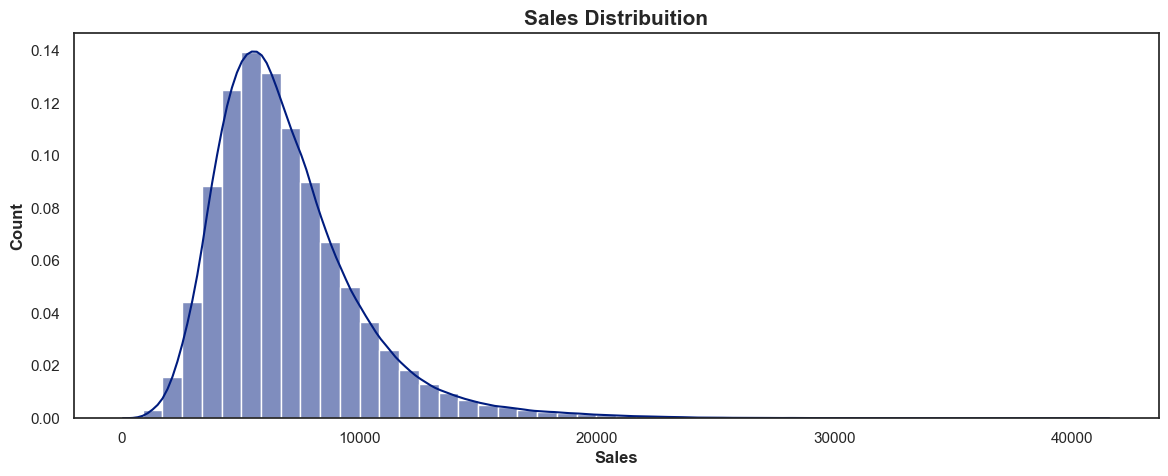

In [40]:
sns.set_theme(style="white", palette='dark')
plt.figure(figsize=(14, 5))
sns.histplot( df4['sales'], kde=True, stat='proportion', bins=50)
plt.title('Sales Distribuition', fontsize=15, fontweight='bold')
plt.xlabel('Sales', fontweight='bold')
plt.ylabel('Count', fontweight='bold');

__Interpretation:__ Bell-shaped with high kurtosis, with skew more to the left (positive). Does not present a normal curve and will require some normalization method before creating machine learning models.

### 6.1.2 Numerical Variables

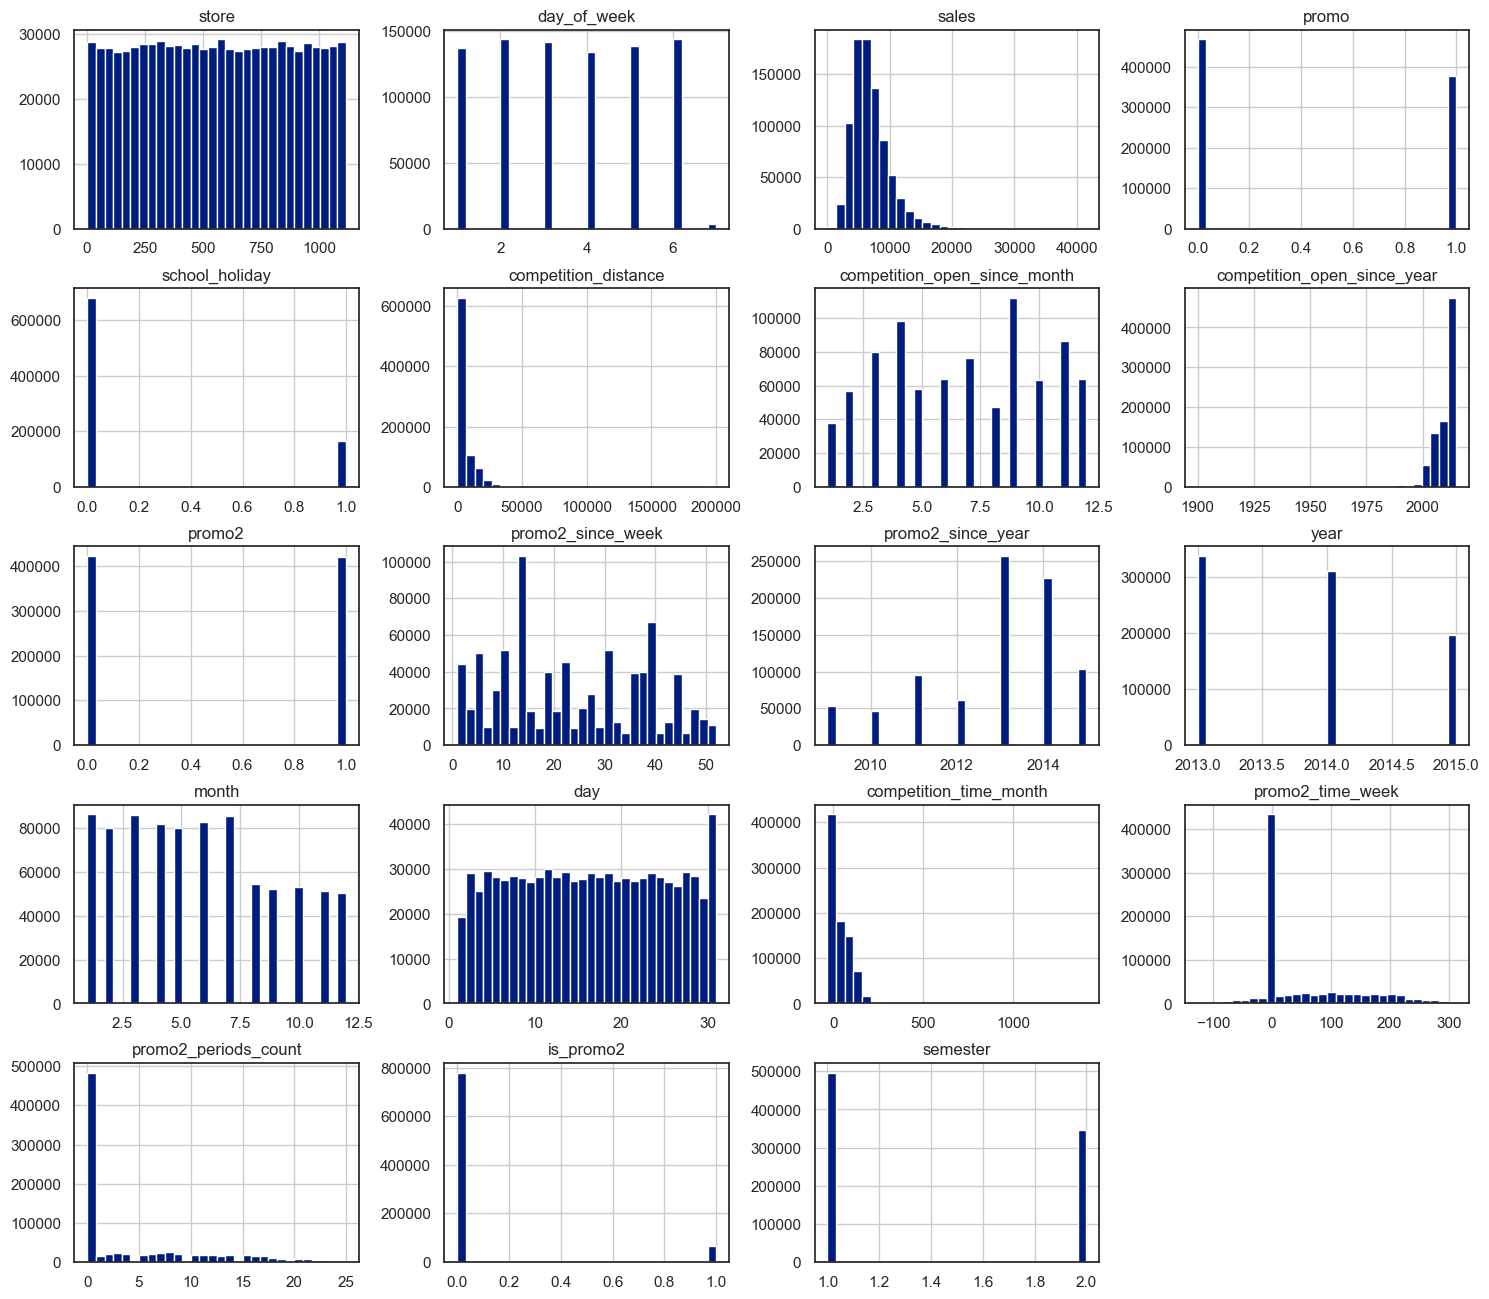

In [41]:
num_attributes.hist( bins=30, figsize=(18, 16));

__Some insights:__
* The majority of the stores have competitors located very close by.
* The majority of the stores have recent opened competitors stores.
* The majority competitors stores were open after the year 2000.
* The dataset provides sales data for the years 2013, 2014 and 2015.
* There is less data for 2015 probably because the entire period of the year was not considered.
* There is an equal distribution between stores that participate and those that do not participate in extended promotions.
* Most of the records in the dataset were during periods in which extended promotions are not taking place.

## 6.1.3 Categorical Variables

In [42]:
df4['state_holiday'].drop_duplicates()

0            regular day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<Axes: xlabel='count', ylabel='state_holiday'>

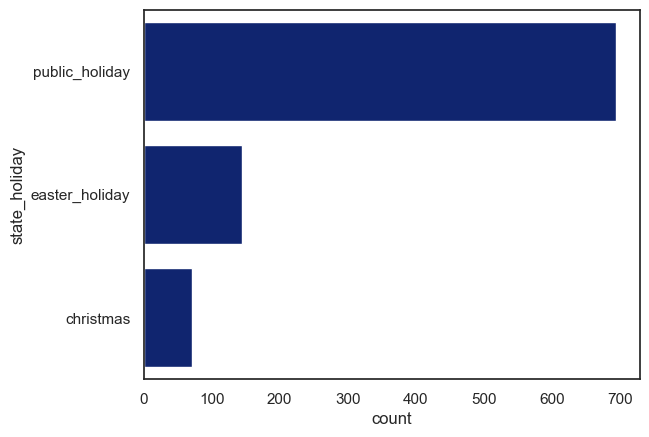

In [43]:
a = df4[df4['state_holiday'] != 'regular day']
sns.countplot( a['state_holiday'])


<Axes: xlabel='sales', ylabel='Density'>

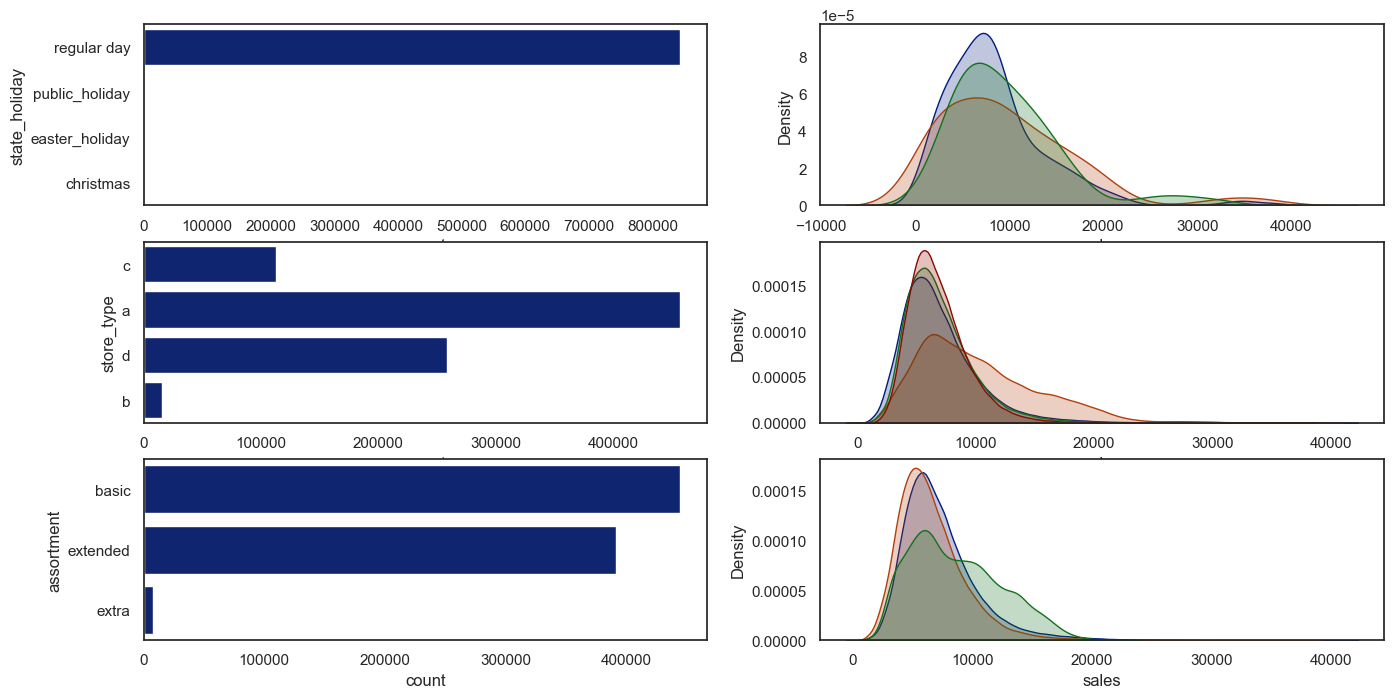

In [44]:
plt.figure(figsize=(16, 8))

# state_holiday.
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type.
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )
plt.grid(False)

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment.
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

## 6.2 Bivariate Analysis (Hypothesis validation)

### H1. Stores with a larger assortment should sell more.

***TRUE*** Stores with larger assortment tend to have higher average sales.

###  Insights:

* Rossmann has the largest number of stores of the 'basic' (593), 'extended' (513) and 'extra' (9) types, consecutively.
* Stores with the basic assortment represent the majority of sales made by Rossmann stores (50%), and the extra stores represent 49% of total sales, caused by the large number of basic and extra stores, in relation to the low number of extended stores.



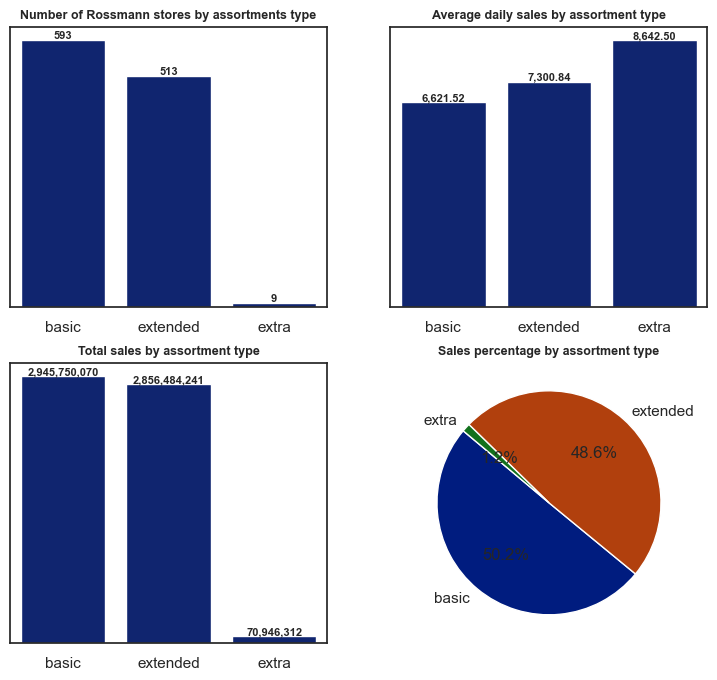

In [180]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
aux2 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
aux3 = df4[['assortment', 'store']].groupby('assortment').nunique().reset_index()

plt.figure(figsize=(9, 8))

# Number of stores.
plt.subplot( 2, 2, 1 )
barplot(aux3, 'assortment', 'store', 'Number of Rossmann stores by assortments type', '{:,.0f}')

# Average dayle sales.
plt.subplot( 2, 2, 2 )
barplot(aux1, 'assortment', 'sales', 'Average daily sales by assortment type', '{:,.2f}')
# Total sales by assortment.
plt.subplot( 2, 2, 3 )
barplot(aux2, 'assortment', 'sales', 'Total sales by assortment type', '{:,.0f}')

# Percentage of sales.
plt.subplot( 2, 2, 4 )
assortment_labels = aux2['assortment']
stores_count = aux2['sales']
plt.pie(stores_count, labels=assortment_labels, autopct='%1.1f%%', startangle=140);
plt.title('Sales percentage by assortment type', fontsize=9, fontweight='bold');



### H2. Stores with closer competitors should sell less.

**FALSE** There is no pattern that indicates that stores with closer competitors sell less.

### Insights:
* The majority of Rossmann stores are located close to other competitors stores.
* The fact that there are nearby competitors does not reduce the sales of these stores compared to stores with distant competitors.
* Stores with nearby competitors are probably located in commercial centers where there is a high circulation of people and potential customers, causing the competition effect to be mitigated by the large volume of potential customers.
* In general, stores with nearby competitors (0 to 1000 m) represent a large volume of total sales of Rossmann stores.
* Stores where the closest competitors are between 15km and 16km away have a higher average sales.

In [105]:
bins = list(np.arange(0, 20000, 1000))

aux1 = df4[['competition_distance', 'store', 'sales']].reset_index(drop=True)
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux1.dropna(inplace=True)


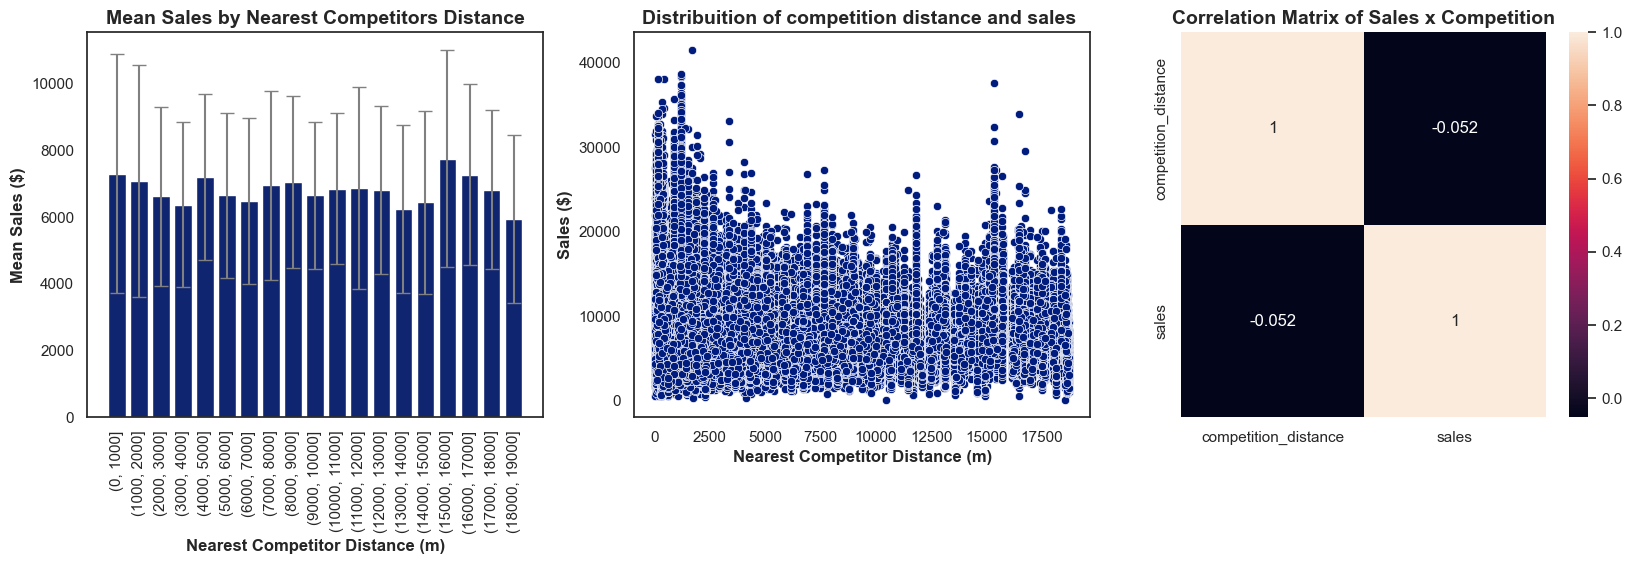

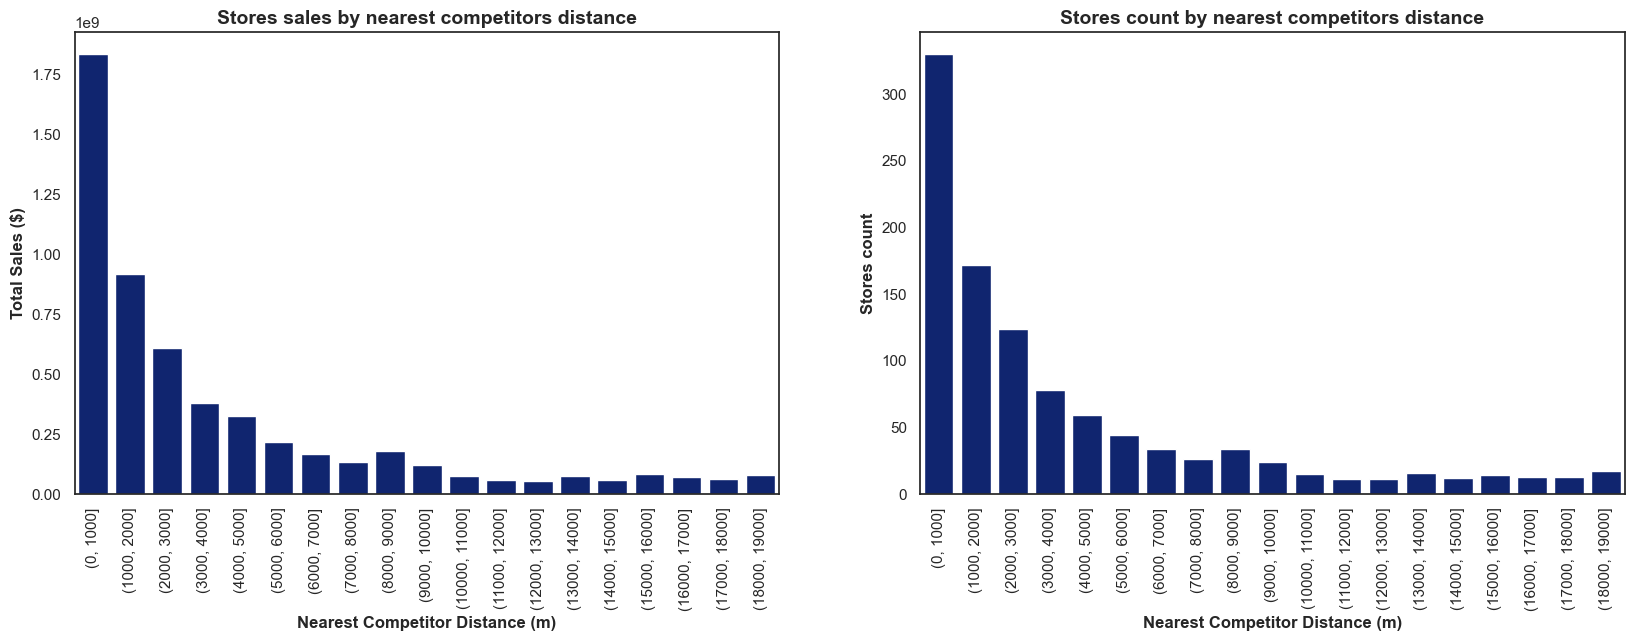

In [106]:
plt.figure(figsize=(20, 5))

# Barplot.
plt.subplot(1,3,1)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').agg(['mean', 'std']).reset_index()
aux2.columns = ['competition_distance_binned', 'mean_sales', 'std_sales']

bars = sns.barplot(x='competition_distance_binned', y='mean_sales', data=aux2, ci=None)
for bar, std in zip(bars.patches, aux2['std_sales']):
    height = bar.get_height()
    plt.errorbar(
        bar.get_x() + bar.get_width() / 2.0, 
        height,
        yerr=std,  
        fmt='none', 
        color='grey',  
        capsize=5 
    )
plt.xticks(rotation=90)
plt.xlabel('Nearest Competitor Distance (m)', fontweight='bold')
plt.ylabel('Mean Sales ($)', fontweight='bold')
plt.title('Mean Sales by Nearest Competitors Distance', fontsize=14, fontweight='bold')

# scatterplot.
plt.subplot(1,3,2)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)
plt.xlabel('Nearest Competitor Distance (m)', fontweight='bold')
plt.ylabel('Sales ($)', fontweight='bold')
plt.title('Distribuition of competition distance and sales ', fontsize=14, fontweight='bold')

# correlation matrix.
plt.subplot(1,3,3)
aux3 = aux1[['competition_distance', 'sales']]
sns.heatmap(aux3.corr(method='pearson'), annot=True)
plt.title('Correlation Matrix of Sales x Competition', fontsize=14, fontweight='bold');

plt.figure(figsize=(20, 6))

plt.subplot(1,2,1)

# Plot.
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)
plt.xlabel('Nearest Competitor Distance (m)', fontweight='bold')
plt.ylabel('Total Sales ($)', fontweight='bold')
plt.title('Stores sales by nearest competitors distance', fontsize=14, fontweight='bold')

plt.subplot(1,2,2)
# Plot.
aux2 = aux1[['competition_distance_binned', 'store']].groupby('competition_distance_binned').nunique().reset_index()
sns.barplot( x='competition_distance_binned', y='store', data=aux2)
plt.xticks(rotation=90)
plt.xlabel('Nearest Competitor Distance (m)', fontweight='bold')
plt.ylabel('Stores count', fontweight='bold')
plt.title('Stores count by nearest competitors distance', fontsize=14, fontweight='bold');

### H3. Stores with longer-term store competitors should sell more.

**FALSE** There is a slight tendency for sales averages to decline as the competition time increases.

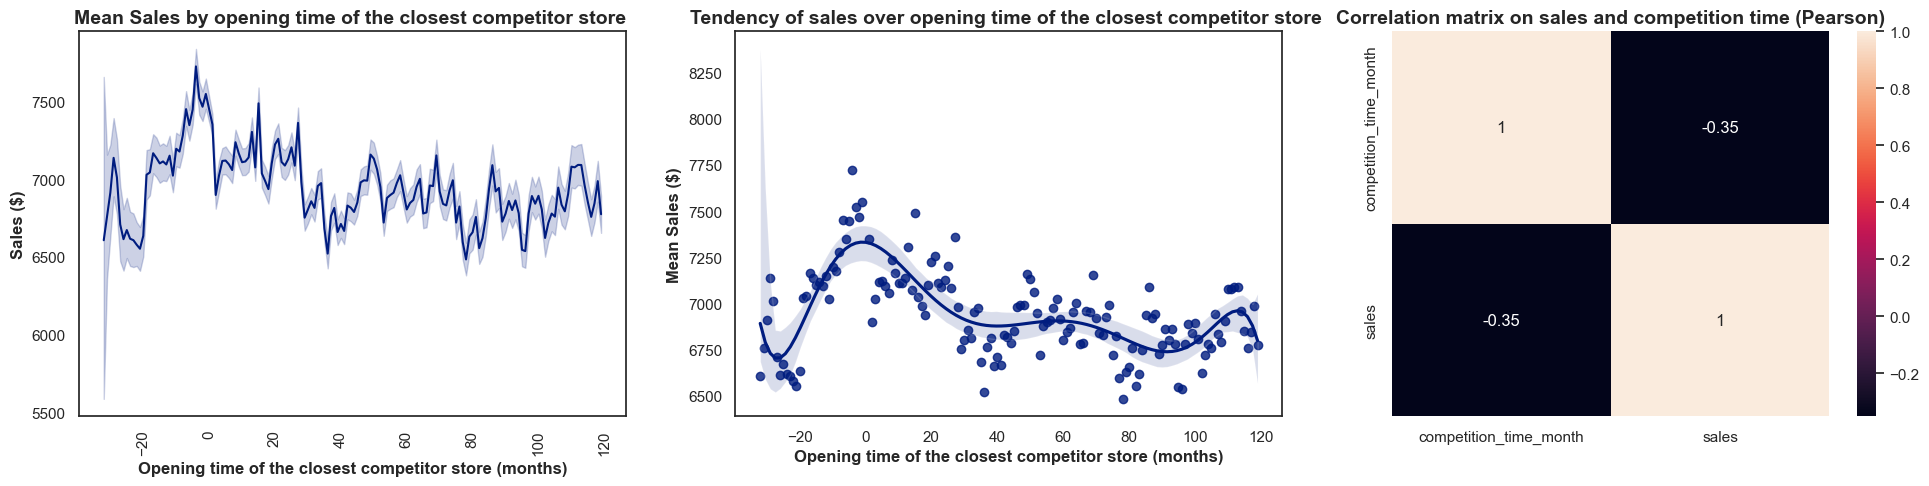

In [107]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).mean().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
aux3 = df4[( df4['competition_time_month'] < 120 ) & (df4['competition_time_month'] != 0 )]

plt.figure(figsize=(24, 5))

plt.subplot( 1, 3, 1 )
sns.lineplot( x='competition_time_month', y='sales', data=aux3 );
plt.xticks( rotation=90 )
plt.xlabel('Opening time of the closest competitor store (months)', fontweight='bold')
plt.ylabel('Sales ($)', fontweight='bold')
plt.title('Mean Sales by opening time of the closest competitor store ', fontsize=14, fontweight='bold')

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2, order=10)
plt.xlabel('Opening time of the closest competitor store (months)', fontweight='bold')
plt.ylabel('Mean Sales ($)', fontweight='bold')
plt.title('Tendency of sales over opening time of the closest competitor store ', fontsize=14, fontweight='bold')

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux2.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
plt.title('Correlation matrix on sales and competition time (Pearson)', fontsize=14, fontweight='bold');


### H4. Stores with promotions running for longer should sell more.

**FALSE** There is a weak indication that stores sell more with more promotional days.

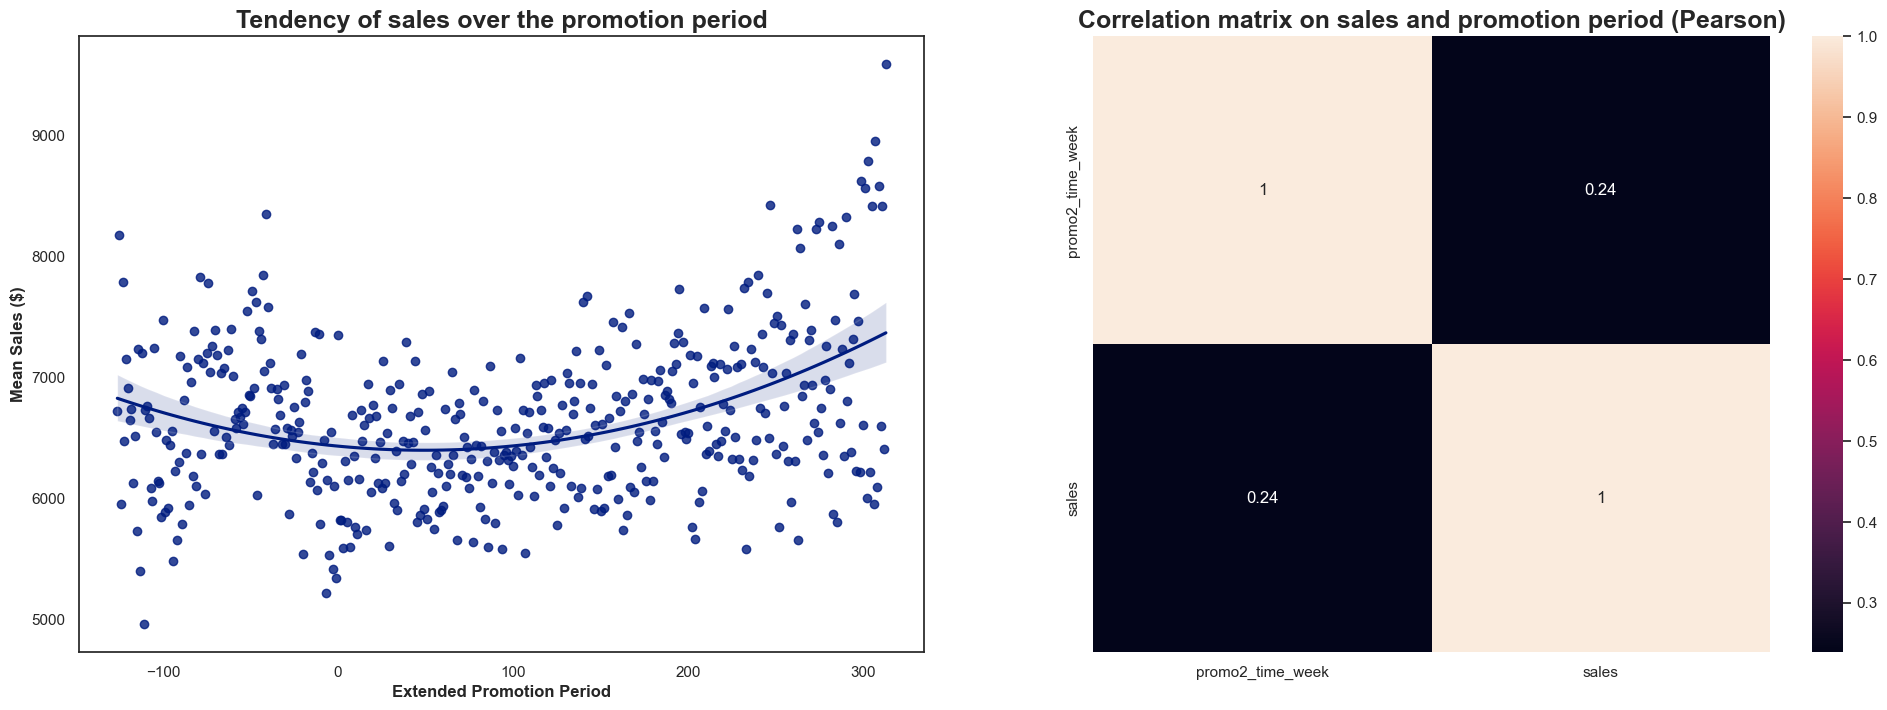

In [108]:
aux1 = df4[['promo2_time_week', 'sales']].groupby('promo2_time_week').mean().reset_index()

plt.figure(figsize=(24, 8))

plt.subplot( 1, 2, 1 )
sns.regplot(data=aux1, x='promo2_time_week', y='sales', order=2)
plt.xlabel('Extended Promotion Period', fontweight='bold')
plt.ylabel('Mean Sales ($)', fontweight='bold')
plt.title('Tendency of sales over the promotion period', fontsize=18, fontweight='bold')

plt.subplot( 1, 2, 2 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True )
plt.title('Correlation matrix on sales and promotion period (Pearson)', fontsize=18, fontweight='bold');

### H5. Stores with more consecutive promotions should sell more.

**FALSE** Stores with more consectuive promotions sell less.

In [43]:
promo_count = df4[df4['is_promo2'] == 1].groupby('store').size().reset_index(name='promo_count')
sales_mean = df4[df4['is_promo2'] == 1].groupby('store')['sales'].mean().reset_index(name='sales_mean')
aux5 = promo_count.merge(sales_mean, on='store', how='outer')
aux5['promo_count'].fillna(0, inplace=True)
aux5.sort_values(by='promo_count')


,store,promo_count,sales_mean
492,1073,9,6686.555556
487,1065,22,5426.409091
254,547,22,6890.454545
398,875,23,5342.086957
399,876,23,9364.217391
...,...,...,...
243,519,284,5060.014085
66,140,284,7254.616197
108,244,284,5078.137324
131,300,285,6916.919298


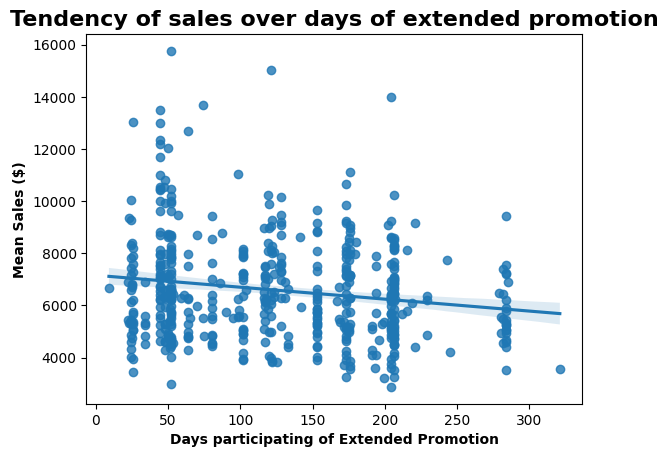

In [44]:
sns.regplot(data=aux5, x='promo_count',  y='sales_mean')
plt.xlabel('Days participating of Extended Promotion', fontweight='bold')
plt.ylabel('Mean Sales ($)', fontweight='bold')
plt.title('Tendency of sales over days of extended promotion', fontsize=16, fontweight='bold');

### H6. Stores opened during the Christmas holidays should sell more.

**TRUE** Stores open during Christmas tend to sell more than on other holidays.

### Insights:
* On average, stores sell more on Christmas than on other holidays and on regular days.
* In 2014, Easter sales were higher than Christmas sales.
* In general, stores sell more on holidays than on regular days.
* In descending order, stores tend to sell more during Christmas, Easter, public holidays, and regular days.

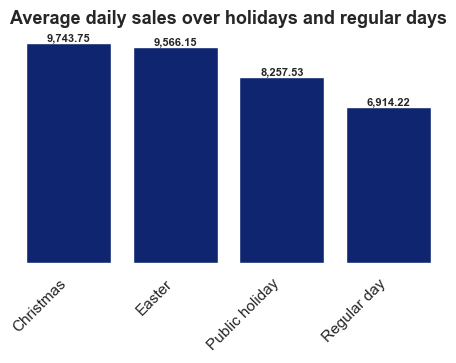

In [111]:
aux = df4[df4['year'] != 2015]
plt.figure(figsize=(5.5, 3))

aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()
ax = sns.barplot(x='state_holiday', y='sales', data=aux1)
new_labels = ['Christmas', 'Easter', 'Public holiday', 'Regular day']
ax.set_xticklabels(new_labels, rotation=45, ha='right')
plt.xlabel('')
plt.ylabel('')
plt.yticks([])
plt.title('Average daily sales over holidays and regular days', fontsize=13, fontweight='bold')
sns.despine(left=True, bottom=True)
ax.bar_label(ax.containers[0], fmt='{:,.2f}', fontsize=8, fontweight='bold'); 

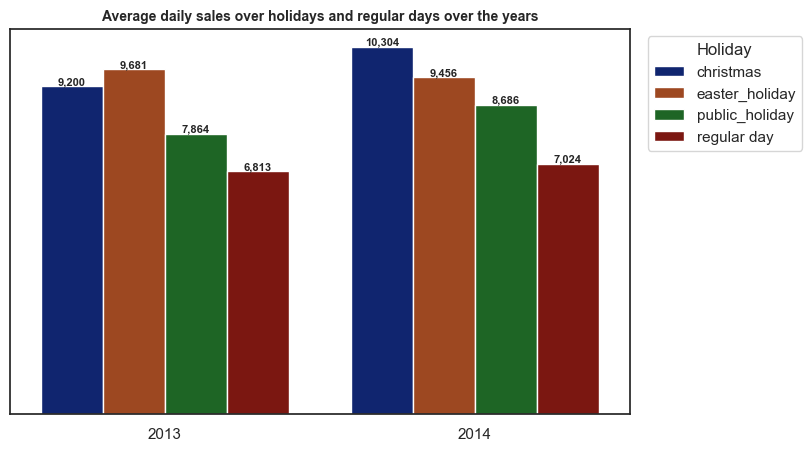

In [123]:
plt.figure(figsize=(8, 5))
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).mean().reset_index()
plot = sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)
plt.xlabel('')
plt.ylabel('')
plt.yticks([])
plt.title('Average daily sales over holidays and regular days over the years', fontsize=10, fontweight='bold')
plt.legend(title='Holiday', loc='upper right', bbox_to_anchor=(1.29, 1))
for container in plot.containers:
    plot.bar_label(container, fmt='{:,.0f}', fontsize=8, fontweight='bold')

### H7. Stores should sell more over the years.

**FALSE** Stores sell less over the years.

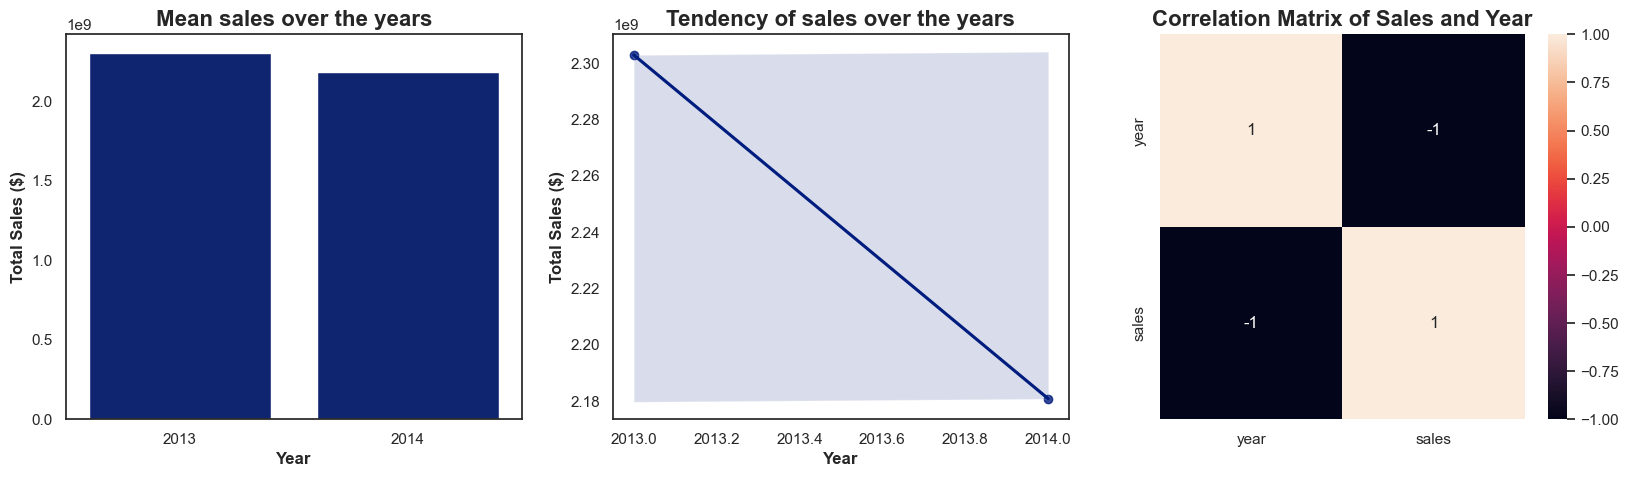

In [127]:
aux1 = df4[df4['year'] != 2015]
aux1 = aux1[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.figure(figsize=(20, 5))
plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 )
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Total Sales ($)', fontweight='bold')
plt.title('Mean sales over the years', fontsize=16, fontweight='bold');

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 )
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Total Sales ($)', fontweight='bold')
plt.title('Tendency of sales over the years', fontsize=16, fontweight='bold');

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True )
plt.title('Correlation Matrix of Sales and Year', fontsize=16, fontweight='bold');

### H8. Stores should sell more in the second half of the year.

**TRUE** Stores tend to sell more in the second half of the year.

### Insights:

* The biggest sales variations tend to be monthly rather than half-yearly
* In 2013 and 2014, there was a decrease in sales in August and a progressive increase from October to December.
* December is when most sales occur, which impacts the increase in total sales in the second half of the year compared to the first.

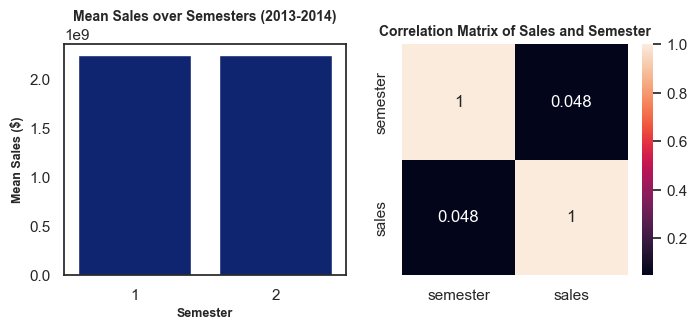

In [154]:
aux1 = df4[df4['year'] != 2015]
aux2 = df4[['month', 'year', 'sales']].groupby(['month', 'year']).sum().reset_index()
aux3 = aux1[['semester', 'sales']].groupby( 'semester' ).sum().reset_index()
aux4 = aux1[['semester', 'sales']]

plt.figure(figsize=(8, 3))

plt.subplot( 1, 2, 1 )
sns.barplot( x='semester', y='sales', data=aux3)
plt.xlabel('Semester', fontweight='bold', fontsize=9)
plt.ylabel('Mean Sales ($)', fontweight='bold', fontsize=9)
plt.title('Mean Sales over Semesters (2013-2014)', fontsize=10, fontweight='bold');

plt.subplot( 1, 2, 2 )
sns.heatmap( aux4.corr( method='pearson' ), annot=True )
plt.title('Correlation Matrix of Sales and Semester', fontsize=10, fontweight='bold');

Text(0.5, 1.0, 'Monthly sales over the years')

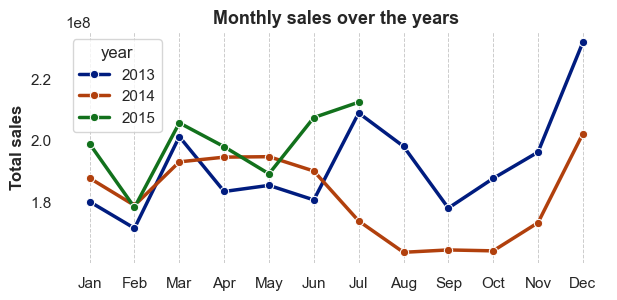

In [89]:
plt.figure(figsize=(7, 3))
sns.lineplot(data = aux2, x='month', y='sales', hue='year', marker='o', linewidth=2.5, palette = 'dark')

month_abbr = [calendar.month_abbr[i] for i in range(1, 13)]
plt.xticks(ticks=range(1, 13), labels=month_abbr)
plt.grid(axis='x', linestyle='--', linewidth=0.7)

sns.despine(left=True, bottom=True)

plt.xlabel('')
plt.ylabel('Total sales', fontweight='bold')
plt.title('Monthly sales over the years', fontsize=13, fontweight='bold')

### H9. Stores should sell more after the 10th of each month.

**TRUE** Stores sell more after the 10th of each month.

### Insights:

* Although the total sum of sales after the 10th is higher than before the 10th, sales tend to oscilate throughout the days of the month.
* The greater concentration of sales after the 10th is certainly explained by the fact that 20 days (from the 10th to the 30th) of sales are being compared with 9 days of sales (from the 1st to the 9th).

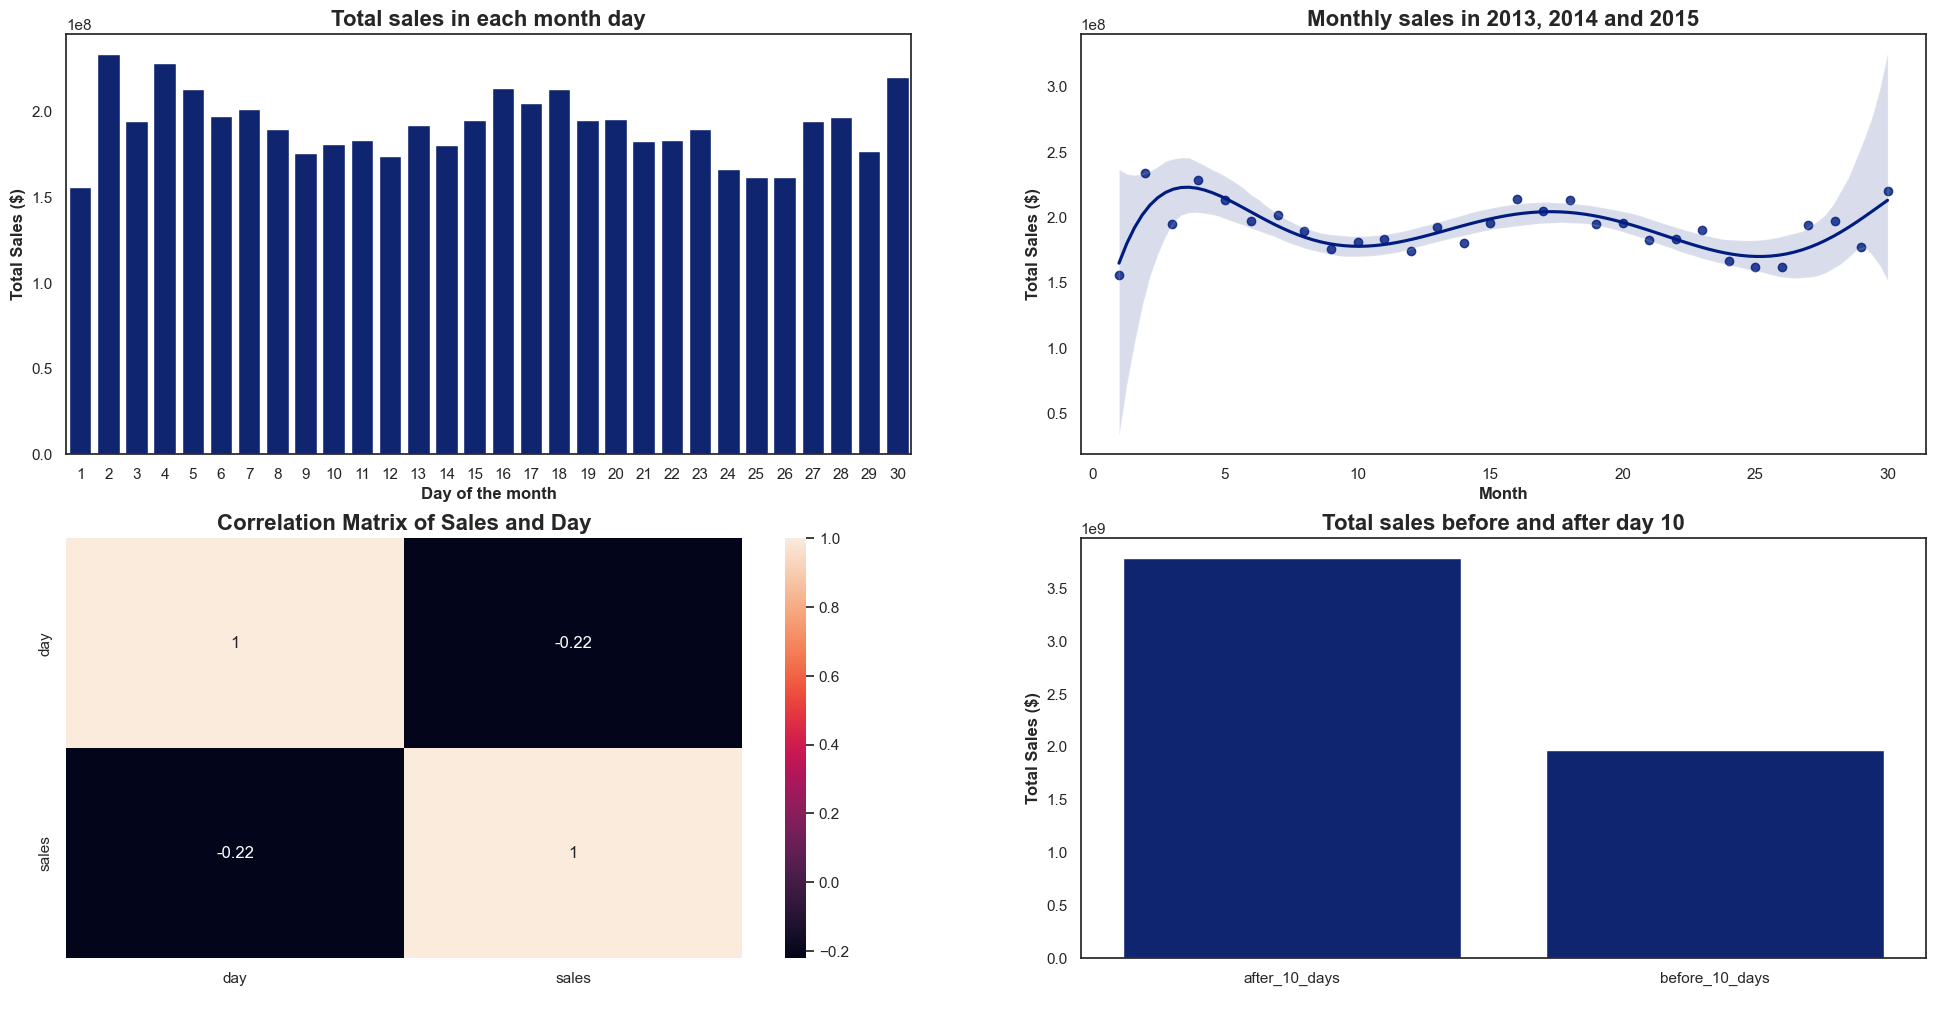

In [155]:
aux1 = df4[df4['day'] != 31]
aux1 = aux1[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.figure(figsize=(24, 12))
plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 )
plt.xlabel('Day of the month', fontweight='bold')
plt.ylabel('Total Sales ($)', fontweight='bold')
plt.title('Total sales in each month day', fontsize=16, fontweight='bold');

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1, order=6 )
plt.xlabel('Month', fontweight='bold')
plt.ylabel('Total Sales ($)', fontweight='bold')
plt.title('Monthly sales in 2013, 2014 and 2015', fontsize=16, fontweight='bold');

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True )
plt.title('Correlation Matrix of Sales and Day', fontsize=16, fontweight='bold');

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 )
plt.xlabel(' ', fontweight='bold')
plt.ylabel('Total Sales ($)', fontweight='bold')
plt.title('Total sales before and after day 10', fontsize=16, fontweight='bold');


### H10. Stores should sell less in the weekends.

**TRUE** The stores tend to sell less during the weekend in relation to weekdays.

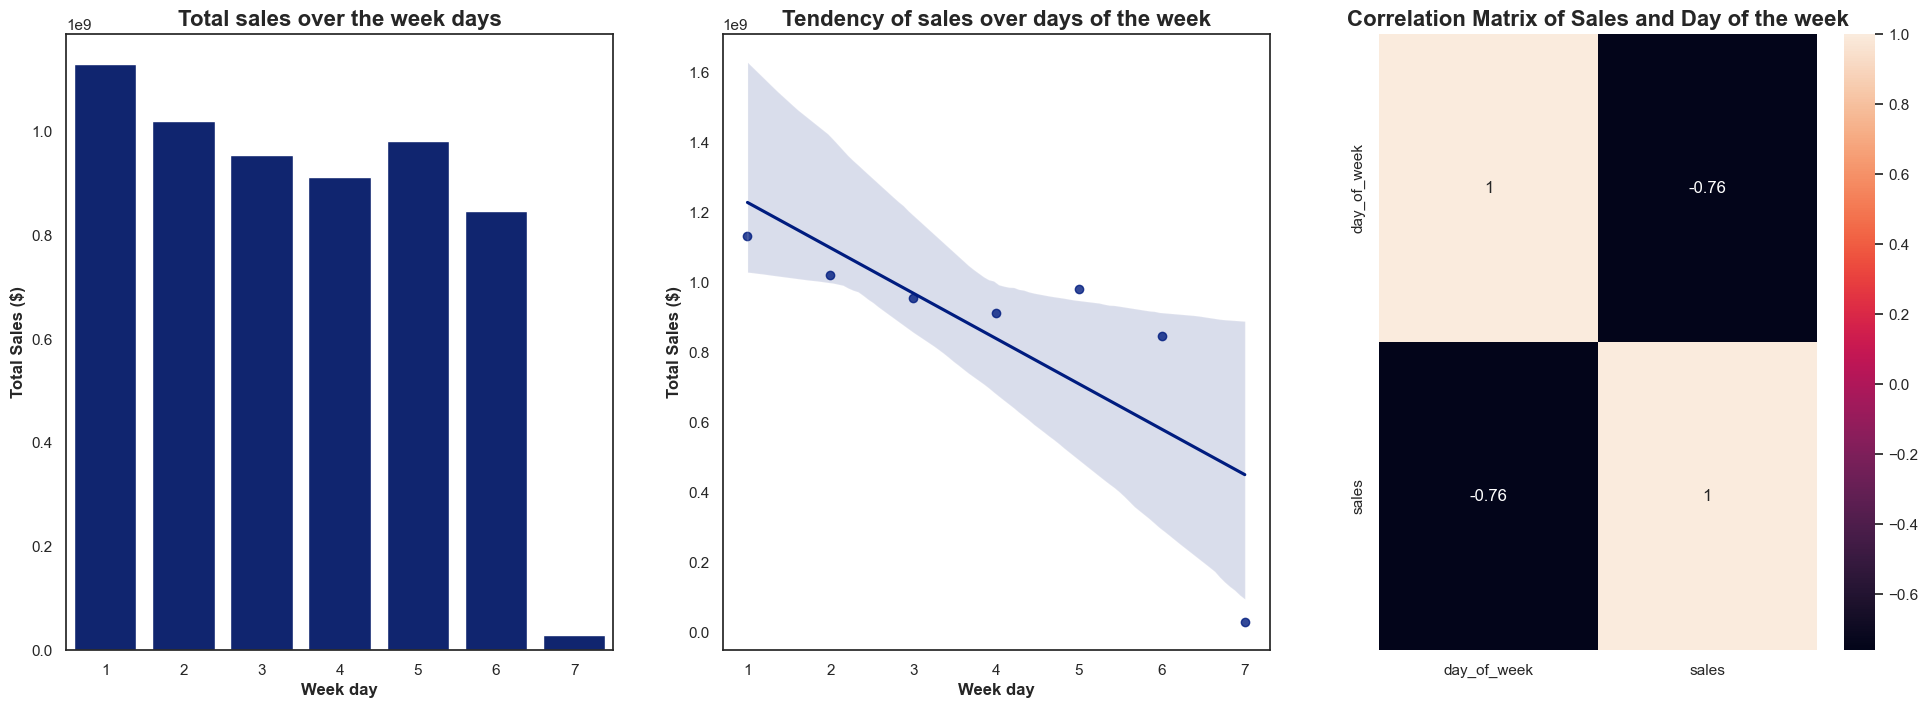

In [156]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.figure(figsize=(24, 8))

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 )
plt.xlabel('Week day', fontweight='bold')
plt.ylabel('Total Sales ($)', fontweight='bold')
plt.title('Total sales over the week days', fontsize=16, fontweight='bold');

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 )
plt.xlabel('Week day', fontweight='bold')
plt.ylabel('Total Sales ($)', fontweight='bold')
plt.title('Tendency of sales over days of the week', fontsize=16, fontweight='bold');

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True )
plt.title('Correlation Matrix of Sales and Day of the week', fontsize=16, fontweight='bold');

### H11. Stores should sell less during school holidays.

**TRUE** Stores tend to sell a little more during school holidays.

### Insight:

* December is the only month where sales are higher on non-school holidays, likely influenced by the festive season and high sales during Christmas and New Year.

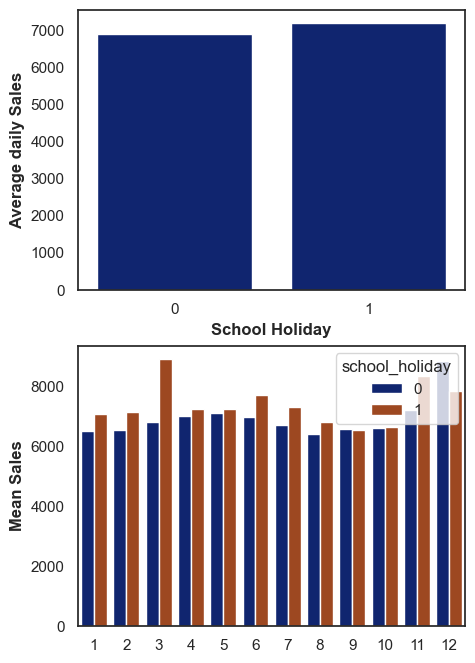

In [172]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday' ).mean().reset_index()

plt.figure(figsize=(5, 8))

plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 )
plt.xlabel('School Holiday', fontweight='bold')
plt.ylabel('Average daily Sales', fontweight='bold')
plt.title('');

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).mean().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 )
plt.xlabel('')
plt.ylabel('Mean Sales', fontweight='bold');


## 6.2.1 Summary of Hypotheses

In [173]:
tab =[['Hypothesis', 'Conclusion'],
      ['H1', 'True'],
      ['H2', 'False'],
      ['H3', 'False'],
      ['H4', 'False'],
      ['H5', 'False'],
      ['H6', 'True'],
      ['H7', 'False'],
      ['H8', 'True'],
      ['H9', 'True'],
      ['H10', 'True'],
      ['H11', 'True']
     ]
print( tabulate( tab, headers='firstrow' ) )

Hypothesis    Conclusion
------------  ------------
H1            True
H2            False
H3            False
H4            False
H5            False
H6            True
H7            False
H8            True
H9            True
H10           True
H11           True


## 6.3 Multivariate Analysis

### 6.3.1 Numerical Attributes

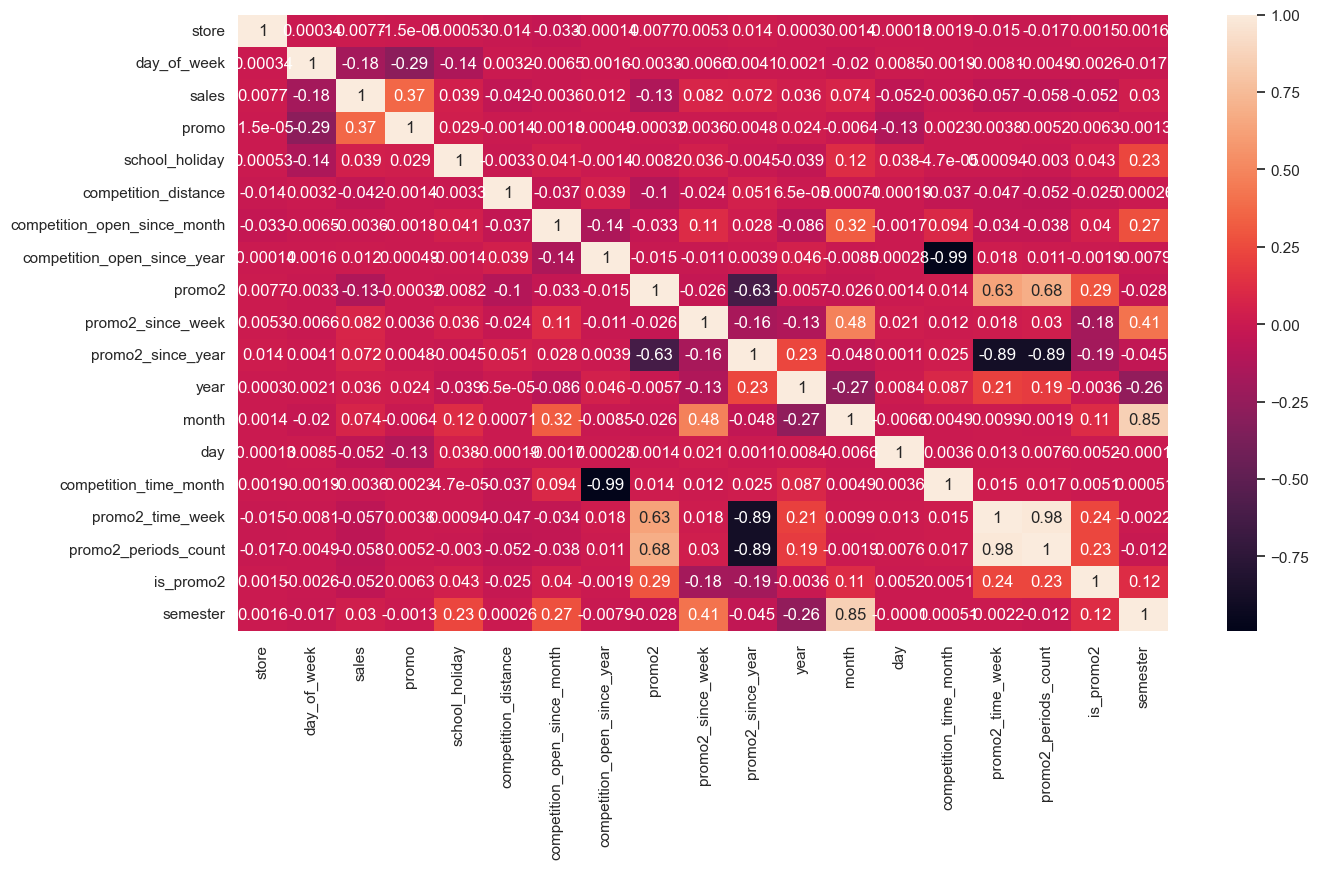

In [174]:
# Select only categorical data
a = df4.select_dtypes(include=['int', 'float'])

correlation = a.corr(method='pearson')
plt.figure(figsize=(15 , 8))
sns.heatmap(correlation, annot=True);

### 6.3.2 Categorical Attributes

In [175]:
a

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,year,month,day,competition_time_month,promo2_time_week,promo2_periods_count,is_promo2,semester
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,2015,7,31,84,0,0,0,2
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,2015,7,31,94,279,22,1,2
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,2015,7,31,105,226,18,1,2
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,2015,7,31,71,0,0,0,2
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,2015,7,31,4,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,3375,0,1,150.0,9,2006,0,1,2013,2013,1,1,77,0,0,0,1
1016827,733,2,10765,0,1,860.0,10,1999,0,1,2013,2013,1,1,161,0,0,0,1
1016863,769,2,5035,0,1,840.0,1,2013,1,48,2012,2013,1,1,0,6,0,0,1
1017042,948,2,4491,0,1,1430.0,1,2013,0,1,2013,2013,1,1,0,0,0,0,1


<Axes: >

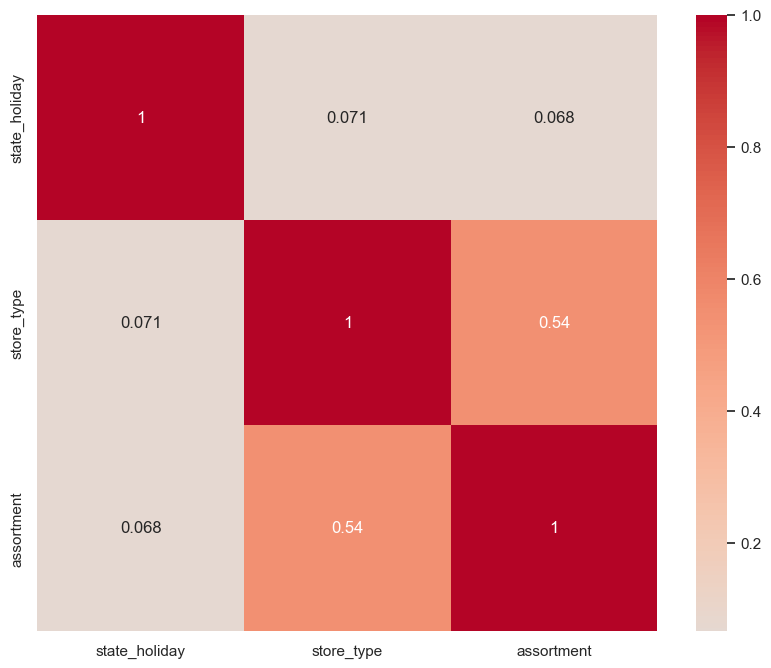

In [176]:
# Select only categorical data
a = df4.select_dtypes( include='object' )


# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )


# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 'store_type': [a4, a5, a6], 'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
plt.figure(figsize=(10 , 8))
sns.heatmap( d, annot=True, cmap='coolwarm', center=0)

#Interpretation: near 0 (no association), near 1 perfect association

# 7. DATA PREPARATION

In [45]:
df5 = df4.copy()

* No normalization will be applied due to lack of normal distribuited data among the columns (check graphs in the section 6.1.)

## 7.1. Rescaling

* The transformations using **Robust Scales** will be applied to transform columns that contains outliers.
* The method of **MinMaxScaler** will be applied in columns that haven't considerable outliers, defining the values between 0 and 1.

In [46]:
## RobustScaler (Apllied over the columns with outlier): 
rs = RobustScaler()

# competition_distance.
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
# pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition_time_month.
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )
# pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )


## MinMaxScaler (Applied over the columns without or not revelant outliers):
mms = MinMaxScaler() 

# promo2_time_week.
df5['promo2_time_week'] = mms.fit_transform( df5[['promo2_time_week']].values )
# pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year.
df5['year'] = mms.fit_transform( df5[['year']].values )
# pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

## 7.2. Transformation

### 7.2.1. Enconding

In [47]:
# 'state_holiday' -> One Hot Encoding.
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# 'store_type' -> Label Encoding.
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
# pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# 'assortment' -> Ordinal Encoding.
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 7.2.2. Response Variable Transformation

* The response variable **sales** will be transformed by the logarithm method, in order to obtain a distribuition more "simetric".

In [48]:
df5['sales'] = np.log1p( df5['sales'] )

### 7.2.3.  Nature Transformation

* The cyclical transformation will be applied by converting the date variables ('day_of_week', 'month', 'day' and 'week_of_year') into the sen and cos components, creating a circular representation of the data in order to preserve the continuity between the beginning and the end of the cycles.

In [49]:
# day_of_week.
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )

# month.
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )

# day.
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

#week_of_year.
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2.* np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2.* np.pi/52 ) ) )

# 8. FEATURES SELECTION

In [50]:
df6 = df5.copy()

## 8.1. Split dataframe into training and test dataset

* The dataset will be splited into training and test datasets to avoid data leakage from the training dataset when training the algorithms.
* The separated test dataset will be used to measure the performance of the models, thus avoiding over-optimistic performance when using a dataset that has not been previously seen by the model.
* The dataset will be splited according to dates:
    * Training will be all the lines registered before 19-jun-2019.
    * The test dataset will be the last six weeks, i.e., all lines after 19-jun-2019.

In [51]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo2_since','competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [52]:
# Training dataset:
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Test dataset:
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

# Printing the dates of each dataset:
print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 8.2. Boruta as Feature Selector

In [72]:
# # Prepare the training data
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values  # Drop the 'date' and 'sales' columns
# y_train_n = y_train.values.ravel()  # Flatten the y_train array

# # Define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)


# np.int = np.int32
# np.float = np.float64
# np.bool = np.bool_
# # Define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

# # Fit Boruta
# boruta.fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	13


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	0
Rejected: 	13


BorutaPy(estimator=RandomForestRegressor(n_estimators=64, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x27D2BD62940),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x27D2BD62940, verbose=2)

### 6.2.1. Best Features from Boruta

In [ ]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 8.3. Manual Feature Selection

In [53]:
cols_selected_boruta = [
                        'store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo2_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos'
                        ]

# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 9. MACHINE LEARNING MODELLING

In [54]:
# Creating datasets (train and test) with the cols selected in the boruta method
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation (with sales and date)
x_training = X_train[ cols_selected_boruta_full ]

## 9.1. Avarege Model

In [117]:
# aux1 = x_test.copy()
# aux1['sales'] = y_test.copy()

# # prediction
# aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'} )
# aux1 = pd.merge( aux1, aux2, how='left', on='store' )
# yhat_baseline = aux1['predictions']

# # performance
# baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1(yhat_baseline ) )
# baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 9.2. Linear Regression Model

In [118]:
# # model
# lr = LinearRegression().fit( x_train, y_train )

# # prediction
# yhat_lr = lr.predict( x_test )

# # performance
# lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ) )
# lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 9.2.1. Linear Regression Model - Cross Validation

In [119]:
# lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr,verbose=False )
# lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 9.3. Linear Regression Regularized Model

In [120]:
# # model
# lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# # prediction
# yhat_lrr = lrr.predict( x_test )

# # performance
# lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
# lrr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 9.3.1. Lasso - Cross Validation

In [121]:
# lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
# lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 9.4. Random Forest Regressor

In [122]:
# # model
# rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train, y_train )

# # prediction
# yhat_rf = rf.predict( x_test )

# # performance
# rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf ) )
# rf_result


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 9.4.1. Random Forest Regressor - Cross Validation

In [123]:
# rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf,verbose=True )
# rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


## 9.5. XGBoost Regressor

In [124]:
# # model
# model_xgb = xgb.XGBRegressor(  ).fit( x_train, y_train )

# # prediction
# yhat_xgb = model_xgb.predict( x_test )

# # performance
# xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb ) )
# xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,860.433707,0.128868,1232.368137


### 9.5.1. XGBoost Regressor - Cross Validation

In [125]:
# xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor',model_xgb, verbose=True )
# xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1057.93 +/- 145.68,0.15 +/- 0.02,1513.43 +/- 206.0


## 9.6. Compare Model's Performance

In [126]:
# modelling_result = pd.concat( [baseline_result, lr_result, lrr_result,rf_result, xgb_result] )
# modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,XGBoost Regressor,860.433707,0.128868,1232.368137
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


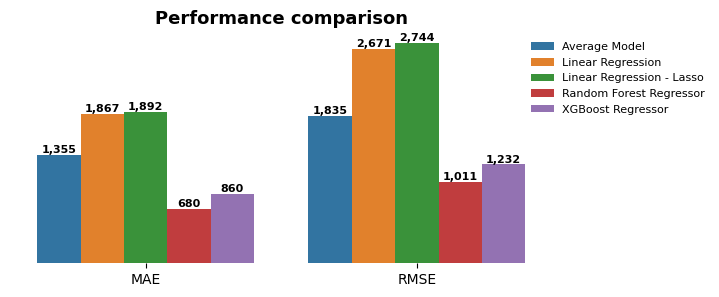

In [175]:
df_long = pd.melt(modelling_result, id_vars=['Model Name'], value_vars=['MAE', 'RMSE'], var_name='Metric', value_name='Value')
plt.figure(figsize=(7, 3))
plot = sns.barplot(x='Metric', y='Value', hue='Model Name', data=df_long)
plt.xlabel('')
plt.ylabel('')
plt.yticks([])
plt.title('Performance comparison', fontsize=13, fontweight='bold')
plt.legend(
    loc='upper right', 
    bbox_to_anchor=(1.3, 1), 
    fontsize='8',     
    frameon=False
)
sns.despine(left=True, bottom=True)

for container in plot.containers:
    plot.bar_label(container, fmt='{:,.0f}', fontsize=8, fontweight='bold');

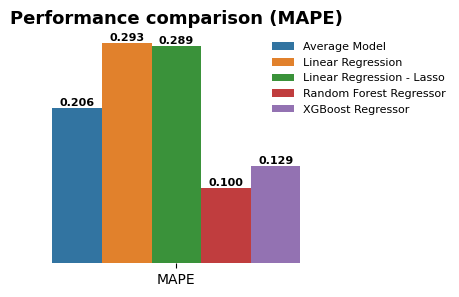

In [177]:
df_long = pd.melt(modelling_result, id_vars=['Model Name'], value_vars=['MAPE'], var_name='Metric', value_name='Value')
plt.figure(figsize=(4, 3))
plot = sns.barplot(x='Metric', y='Value', hue='Model Name', data=df_long)
plt.xlabel('')
plt.ylabel('')
plt.yticks([])
plt.title('Performance comparison (MAPE)', fontsize=13, fontweight='bold')
plt.legend(
    loc='upper right', 
    bbox_to_anchor=(1.4, 1),  
    fontsize='8',      
    frameon=False
)

sns.despine(left=True, bottom=True)

for container in plot.containers:
    plot.bar_label(container, fmt='{:,.3f}', fontsize=8, fontweight='bold');


### 9.6.2. Real Performance - Cross Validation

In [127]:
# modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
# modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost Regressor,1057.93 +/- 145.68,0.15 +/- 0.02,1513.43 +/- 206.0


# 10. HYPERPARAMETER FINE TUNING


## 10.1. Random Search

In [129]:
# param = {
#  'n_estimators': [1500, 1700, 2500, 3000, 3500],
#  'eta': [0.01, 0.03],
#  'max_depth': [3, 5, 9],
#  'subsample': [0.1, 0.5, 0.7],
#  'colsample_bytree': [0.3, 0.7, 0.9],
#  'min_child_weight': [3, 8, 15]
#  }

# MAX_EVAL = 5

In [130]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
#     # choose values for parameters randomly
#     hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#     print( hp )

#     # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'],
#                                   eta=hp['eta'],
#                                   max_depth=hp['max_depth'],
#                                   subsample=hp['subsample'],
#                                   colsample_bytee=hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight'],
#                                   random_state=42)

#     # performance
#     result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#     final_result = pd.concat( [final_result, result] )
# final_result


{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

K

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,935.0 +/- 150.79,0.13 +/- 0.02,1344.05 +/- 210.99
0,XGBoost Regressor,965.03 +/- 134.95,0.14 +/- 0.01,1376.57 +/- 180.89
0,XGBoost Regressor,1669.97 +/- 173.46,0.23 +/- 0.01,2405.49 +/- 221.83
0,XGBoost Regressor,1273.79 +/- 138.85,0.18 +/- 0.01,1846.1 +/- 178.85
0,XGBoost Regressor,861.18 +/- 143.17,0.12 +/- 0.01,1238.89 +/- 206.35


## 10.2. Final Model

In [55]:
param_tuned = {
               'n_estimators': 3000,
               'eta': 0.03,
               'max_depth': 9,
               'subsample': 0.5,
               'colsample_bytree': 0.7,
               'min_child_weight': 3
              }

In [56]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'],
                                    random_state=42 ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,621.314141,0.08981,912.29182


In [57]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

0.004835161007931985

# 11. TRANSLATION AND INTERPRETATION OF ERROR

In [58]:
df9 = X_test[ cols_selected_boruta_full ]

In [59]:
# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 11.1. Business Performance

In [60]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [61]:
df92

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,161651.765625,161384.349359,161919.181891,267.416266,0.060449
1,2,173455.843750,173089.831503,173821.855997,366.012247,0.074575
2,3,262536.968750,261995.053533,263078.883967,541.915217,0.078612
3,4,340049.093750,339148.044803,340950.142697,901.048947,0.085490
4,5,170127.296875,169786.634917,170467.958833,340.661958,0.078458
...,...,...,...,...,...,...
1110,1111,175859.906250,175207.394544,176512.417956,652.511706,0.139046
1111,1112,336989.718750,336063.976760,337915.460740,925.741990,0.112103
1112,1113,232451.781250,231854.619576,233048.942924,597.161674,0.090244
1113,1114,770892.500000,768517.878695,773267.121305,2374.621305,0.100829


In [62]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106050.703125,102748.540592,109352.865658,3302.162533,0.563073
908,909,241575.890625,234155.426100,248996.355150,7420.464525,0.506155
549,550,248254.937500,246744.074272,249765.800728,1510.863228,0.297862
875,876,199546.515625,195569.515678,203523.515572,3976.999947,0.293903
594,595,388059.156250,384244.187685,391874.124815,3814.968565,0.257759


<Axes: xlabel='store', ylabel='MAPE'>

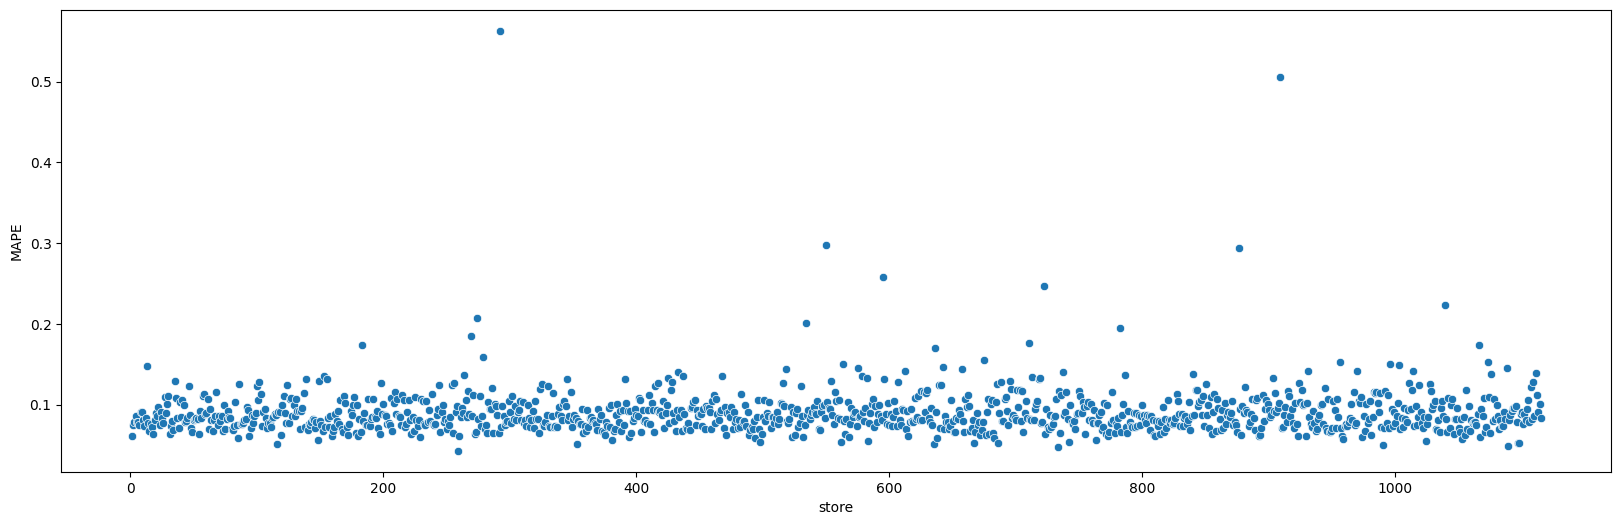

In [63]:
plt.figure(figsize=(20, 6))
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 11.2. Total Performance

In [64]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( '${:,.2f}'.format )
df93


,Scenario,Values
0,predictions,"$283,713,760.00"
1,worst_scenario,"$283,016,725.73"
2,best_scenario,"$284,410,830.30"


## 11.3. Machine Learning Performance

In [65]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']


<Axes: xlabel='predictions', ylabel='error'>

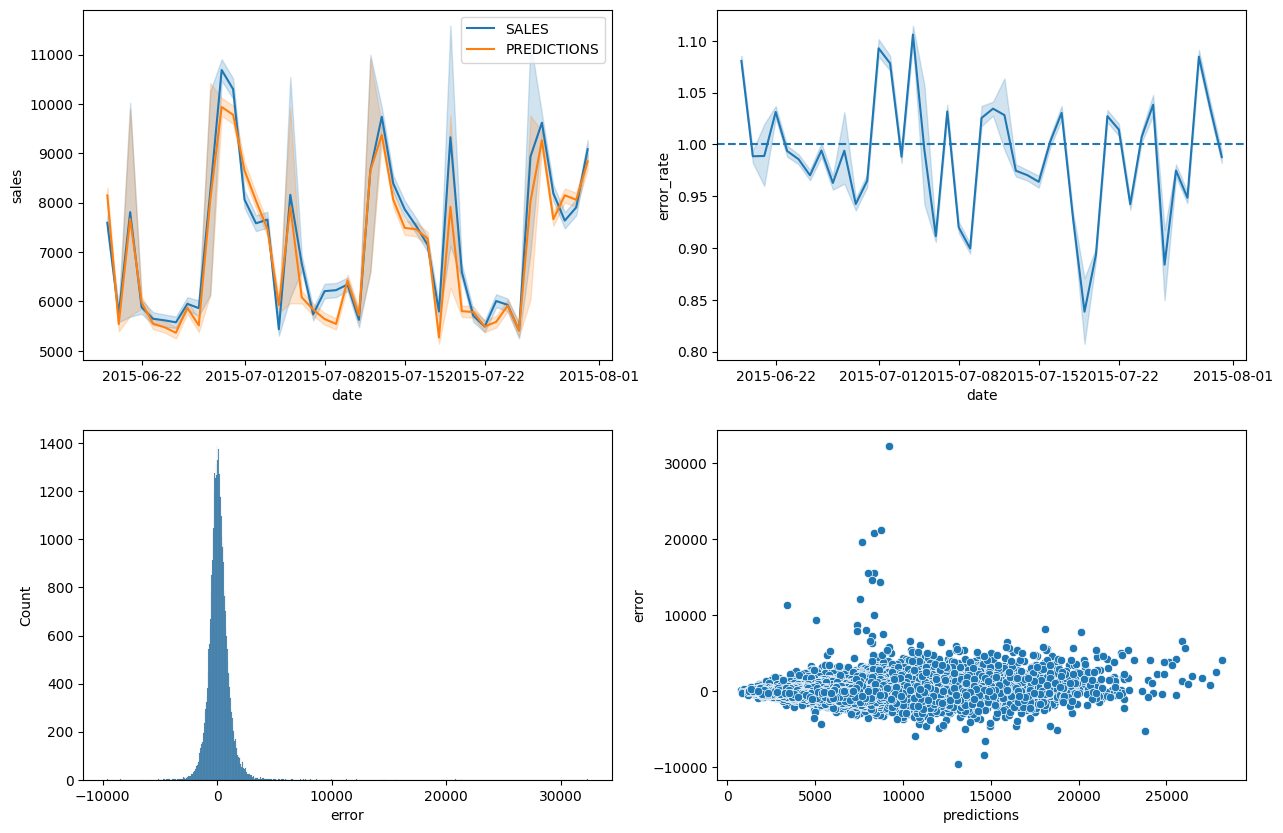

In [66]:
plt.figure(figsize=(15, 10))
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.histplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot(data=df9, x='predictions', y='error' )

In [ ]:
# Save trained Model
pickle.dump(model_xgb_tuned, open('model/model_rossmann.pkl', 'wb'))

# 12. DEPLOY MODEL TO PRODUCTION

In [ ]:
pickle.dump( model_xgb_tuned, open( '/home/priscilaportela/repos/dsemproducao/model/model_rossmann.pkl', 'wb' ) )

## 12.1. Rossman Class

In [ ]:
class Rossmann( object ):
    def __init__( self ):
        self.home_path='/home/priscilaportela/repos/dsemproducao/'
        self.competition_distance_scaler = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
   
    def data_cleaning( self, df1 ):

        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA

        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math. isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace=True )
        df1['month_map'] = df1['date'].dt.month.map( month_map )
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types

        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        return df1
    
    def feature_engineering( self, df2 ):
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. FEATURES FILTER

        ## 3.1. LINE FILTER
        df2 = df2[df2['open'] != 0]

        ## 3.2. COLUMN SELECTION
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        return df2
    
    def data_preparation( self, df5 ):

        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )

        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'],columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        ### 5.3.3. Nature Transformation
        
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
        'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
        'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

        return df5[ cols_selected ]
        
    def get_prediction( self, model, original_data, test_data ):

        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        return original_data.to_json( orient='records', date_format='iso' )

## 12.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/home/priscilaportela/repos/dsemproducao/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )
@app.route( '/rossmann/predict', methods=['POST'])
 
def rossmann_predict():
    test_json = request.get_json()

    if test_json: # there is data

        if isinstance( test_json, dict ): # unique example

        test_raw = pd.DataFrame( test_json, index=[0] )

        else: # multiple example
        test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        return df_response

    else:
        return Reponse( '{}', status=200, mimetype='application/json' )
if __name__ == '__main__':
    app.run( '0.0.0.0' )

IndentationError: expected an indented block after 'if' statement on line 18 (1109528182.py, line 20)

## 12.3. API Tester

In [ ]:
# loading test dataset
df10 = pd.read_csv( 'data/test.csv' )

In [ ]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )


In [ ]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
#url = 'http://172.21.213.59:5000/rossmann/predict'
url = 'https://teste-rossmann-api-8pqd.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [ ]:
#Convert jason to dataframe
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [ ]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,22,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,a,basic,1040.0,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000,0,2012-05-21T00:00:00.000,173,4705.013184
1,22,3,2015-09-16T00:00:00.000,1.0,1,regular_day,0,a,basic,1040.0,...,2015,9,16,38,2015-37,2015-09-01T00:00:00.000,0,2012-05-21T00:00:00.000,173,4762.121094
2,22,2,2015-09-15T00:00:00.000,1.0,1,regular_day,0,a,basic,1040.0,...,2015,9,15,38,2015-37,2015-09-01T00:00:00.000,0,2012-05-21T00:00:00.000,173,5507.601562
3,22,1,2015-09-14T00:00:00.000,1.0,1,regular_day,1,a,basic,1040.0,...,2015,9,14,38,2015-37,2015-09-01T00:00:00.000,0,2012-05-21T00:00:00.000,173,6214.576172
4,22,6,2015-09-12T00:00:00.000,1.0,0,regular_day,0,a,basic,1040.0,...,2015,9,12,37,2015-36,2015-09-01T00:00:00.000,0,2012-05-21T00:00:00.000,172,2673.731934


In [ ]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
        print( "Store number {} will sell ${:,.2f} in the next six weeks.".format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))

Store number 22 will sell $155,086.16 in the next six weeks.
